# Master's Thesis: Low Risk Anomaly Strategy in the Options Market

Auther: Dantong Liu 刘丹彤

Email: dantongliu1999@outlook.com

LinkedIn: http://linkedin.com/in/dantong-liu-273271311

# Summary:

Investing in safer assets while achieving higher returns, the low-risk anomaly has been empirically confirmed as profitable. I tested this anomaly in the US equity options market from 1996 to 2023, sorting options into five moneyness categories based on delta and six maturity groups. After cleaning the data to satisfy no-arbitrage conditions, I conducted monthly delta hedging to mimic the positions of financial intermediaries.

I measured option market risk and aggregate volatility risk using market beta and differential VIX index beta, both derived from underlying stock betas. The option market beta was bimodally distributed with a positive mean, while the differential VIX index beta showed an asymmetric distribution with a negative mean. I constructed Betting Against Beta (BAB) portfolios by going long on lower-beta options and short on higher-beta options. Positive BAB portfolio returns would confirm the low-risk anomaly, and negative returns would refute it.

Additionally, I calculated the SPX option straddle factor as a control variable, since straddle portfolios tend to generate positive returns during economic recessions. If BAB portfolio returns exhibit a near-zero correlation with the straddle factor, the low-risk anomaly would hold in both economic recessions and booms. Hedging market risk proved to be a profitable strategy, but hedging aggregate volatility risk may not be. There was a negative relationship between historical volatility of the underlying stock and option returns. Testing for option idiosyncratic risk presents a potential avenue for future research.



 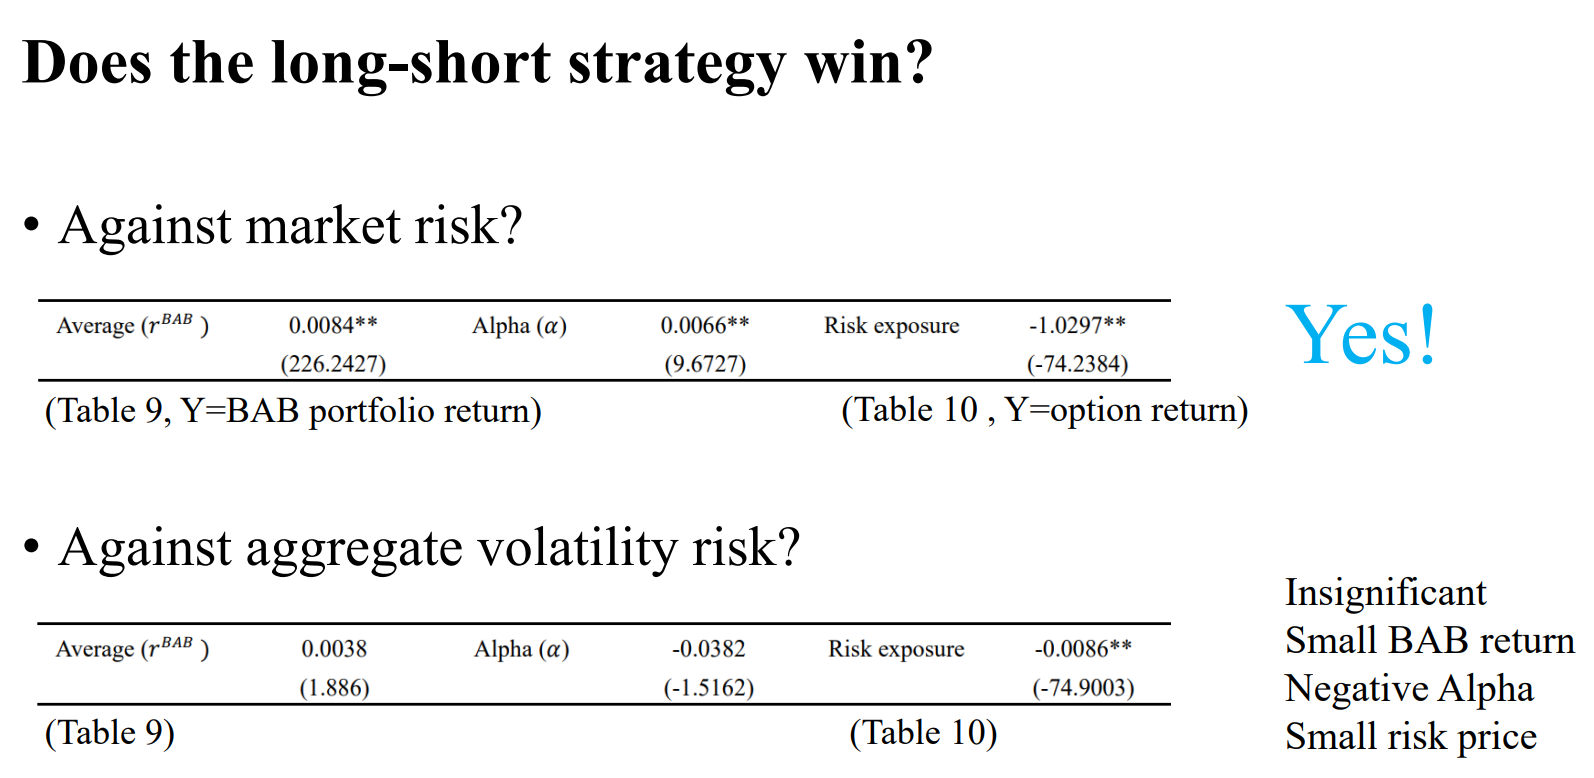



In [ ]:
# connect WRDS
import pandas as pd
import numpy as np
import os
import wrds
import dask
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn
import scikit_posthocs
from scipy.stats import linregress
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import *
from scipy import stats
from datetime import date, timedelta
from datetime import datetime

In [ ]:
# connect WRDS database
db = wrds.Connection(wrds_username='dantongliu')

Loading library list...
Done


In [ ]:
##################################################################
# step1:
# Find out all monthly rebalance dates that are the following Mondays
# after third Fridays every months.
##################################################################

# function to count trading days
def count_workdays(start_date, end_date):
    count = 0
    current_date = start_date
    while current_date < end_date:
        if current_date.weekday() < 5:  # Monday to Friday are considered workdays
            count += 1
        current_date += timedelta(days=1)
    return count


# function to find third friday and following monday
def third_friday_and_rebalance_date(year, month):
    first_day = date(year, month, 1)
    day_of_week = first_day.weekday()
    first_friday = first_day + timedelta(days=(4 - day_of_week + 7) % 7)
    # third friday
    third_friday_date = first_friday + timedelta(weeks=2)
    # rebalance date is the next monday after third friday of a month
    rebalance_date = third_friday_date + timedelta(days=(7 - third_friday_date.weekday()) % 7 + 1)
    return third_friday_date, rebalance_date


# prepare a DataFrame
df_rb = pd.DataFrame(columns=['Year', 'Month', 'ThirdFriday', 'RebalanceDate'])


# store rebalance date
for year in range(1996, 2024):
    for month in range(1, 13):
        third_friday_date, rebalance_date = third_friday_and_rebalance_date(year, month)
        df_rb = pd.concat([df_rb, pd.DataFrame({'Year': [year], 'Month': [month], 'ThirdFriday': [third_friday_date], 'RebalanceDate': [rebalance_date]})], ignore_index=True)


# drop the dates after 2023 Feb
df_rb = df_rb.drop(df_rb.tail(10).index)

# count trading days of each month
df_rb['HoldingDays'] = 0
for i in range(1, len(df_rb)):
    start_date = df_rb.loc[i - 1, 'RebalanceDate']
    end_date = df_rb.loc[i, 'RebalanceDate']
    df_rb.loc[i, 'HoldingDays'] = count_workdays(start_date, end_date)

print(df_rb)

# convert rebalance date to a list
df_rb['RebalanceDate'] = df_rb['RebalanceDate'].astype('datetime64[ns]')
rblist = df_rb['RebalanceDate'].tolist()
print(rblist[:5])

     Year Month ThirdFriday RebalanceDate  HoldingDays
0    1996     1  1996-01-19    1996-01-23            0
1    1996     2  1996-02-16    1996-02-20           20
2    1996     3  1996-03-15    1996-03-19           20
3    1996     4  1996-04-19    1996-04-23           25
4    1996     5  1996-05-17    1996-05-21           20
..    ...   ...         ...           ...          ...
321  2022    10  2022-10-21    2022-10-25           25
322  2022    11  2022-11-18    2022-11-22           20
323  2022    12  2022-12-16    2022-12-20           20
324  2023     1  2023-01-20    2023-01-24           25
325  2023     2  2023-02-17    2023-02-21           20

[326 rows x 5 columns]
[Timestamp('1996-01-23 00:00:00'), Timestamp('1996-02-20 00:00:00'), Timestamp('1996-03-19 00:00:00'), Timestamp('1996-04-23 00:00:00'), Timestamp('1996-05-21 00:00:00')]


In [ ]:
##################################################################
# step2.1: process daily stock price to monthly by rebalance date
##################################################################

# load PERMNO as a list     1 secid and 2 PERMNO
df_secid_PERMNO = pd.read_csv('web_query_output/kllfoxzk9vo1nqqf.csv')
PERMNO_list = df_secid_PERMNO['PERMNO'].dropna().unique().tolist()
PERMNO_list.sort()
PERMNO_list = [int(x) for x in PERMNO_list]
print(PERMNO_list[:5])


# iterative read csv and process data
chunk_size = 10000  # chunk
filtered_chunks = []

# chunk read daily stock data      1 PERMNO, 2 date, 3 PRC, 4 CFACPR
for chunk in pd.read_csv('web_query_output/xg94vpwgdjfe9f6u.csv', chunksize=chunk_size):
    chunk['date'] = pd.to_datetime(chunk['date'])
    # find the rows in rebalance dates
    filtered_chunk = chunk[chunk['date'].isin(rblist)]
    filtered_chunks.append(filtered_chunk)

# rebalance date DataFrame
df_monthlystock = pd.concat(filtered_chunks)

# compute stock price
df_monthlystock['price'] = abs(df_monthlystock['PRC']) / df_monthlystock['CFACPR']
newdf = df_monthlystock[['PERMNO', 'date']].copy()
newdf['price'] = abs(df_monthlystock['PRC']) / df_monthlystock['CFACPR']

# group by 'PERMNO', compute monthly stock return
newdf['monthlyreturn'] = df_monthlystock.groupby('PERMNO')['price'].pct_change()

# drop NAN
newdf = newdf.dropna()
newdf.reset_index(drop=True, inplace=True)

# save the monthlystock data
newdf.to_csv('monthlystock.csv', index=False)

del df_monthlystock

print(newdf)

[10001, 10002, 10009, 10011, 10012]


/tmp/19197845.1.jupyterhub.q/ipykernel_36901/2438893087.py:33: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  newdf['monthlyreturn'] = df_monthlystock.groupby('PERMNO')['price'].pct_change()


         PERMNO       date       price  monthlyreturn
0         10001 1996-02-20    6.250000       0.071429
1         10001 1996-03-19    6.333333       0.013333
2         10001 1996-04-23    6.000000      -0.052632
3         10001 1996-05-21    5.875000      -0.020833
4         10001 1996-06-25    5.500000      -0.063830
...         ...        ...         ...            ...
2387614   93436 2022-10-25  222.414990      -0.279581
2387615   93436 2022-11-22  169.910000      -0.236068
2387616   93436 2022-12-20  137.800000      -0.188982
2387617   93436 2023-01-24  143.890000       0.044194
2387618   93436 2023-02-21  197.370000       0.371673

[2387619 rows x 4 columns]


In [ ]:
##################################################################
# step2.2: process daily Fama-French factors to monthly by rebalance date
##################################################################

# prepare a dataframe
df_monthlyff3 = pd.DataFrame(columns=['End Date', 'Mkt', 'SMB', 'HML', 'RF'])

# load daily Fama-French data 2 Mkt-RF, 3 SMB, 4 HML, 5 RF, 6 date
df_dailyff3 = pd.read_csv('ff3daily.csv')
df_dailyff3['date'] = pd.to_datetime(df_dailyff3['date'])

# loop all rebalance dates
for i in range(len(rblist) - 1):
    start_date = rblist[i]
    end_date = rblist[i + 1]

    # holding period
    filtered_df = df_dailyff3[(df_dailyff3['date'] >= start_date) & (df_dailyff3['date'] < end_date)]

    # convert to monthly returns
    rf = (filtered_df['RF']/100 + 1).prod() - 1
    mkt = (filtered_df['Mkt-RF'] / 100 + 1 + filtered_df['RF'] / 100).prod() - rf - 1
    smb = (filtered_df['SMB'] / 100 + 1).prod() - rf - 1
    hml = (filtered_df['HML'] / 100 + 1).prod() - rf - 1

    # Store data using concat() function
    new_row = {'End Date': end_date, 'Mkt': mkt, 'SMB': smb, 'HML': hml, 'RF': rf}
    df_monthlyff3 = pd.concat([df_monthlyff3, pd.DataFrame([new_row])], ignore_index=True)

print(df_monthlyff3)

# save monthly Fama-French data
df_monthlyff3.to_csv('monthlyff3.csv', index=False)

/tmp/19197845.1.jupyterhub.q/ipykernel_36901/2800686864.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_monthlyff3 = pd.concat([df_monthlyff3, pd.DataFrame([new_row])], ignore_index=True)


      End Date       Mkt       SMB       HML        RF
0   1996-02-20  0.054933 -0.014795 -0.014657  0.003737
1   1996-03-19  0.009169  0.011111 -0.022652  0.003887
2   1996-04-23 -0.001034  0.050897 -0.020168  0.005022
3   1996-05-21  0.044631  0.029878 -0.023166  0.003988
4   1996-06-25 -0.021332 -0.031374  0.015009  0.004731
..         ...       ...       ...       ...       ...
320 2022-10-25 -0.030765 -0.022821  0.049280  0.002573
321 2022-11-22  0.034804 -0.008656  0.028738  0.002653
322 2022-12-20 -0.037459 -0.014235 -0.019928  0.002924
323 2023-01-24  0.056717  0.039204 -0.028648  0.003666
324 2023-02-21  0.016662  0.016873 -0.014911  0.003365

[325 rows x 5 columns]


In [ ]:
##################################################################
# step2.3: merge stock data with Fama-French factors
##################################################################

# load monthly stock
df_monthlystock = pd.read_csv('monthlystock.csv')
df_monthlystock['date'] = pd.to_datetime(df_monthlystock['date'])

# convert to datetime
df_monthlystock['date'] = pd.to_datetime(df_monthlystock['date'])
df_monthlyff3['End Date'] = pd.to_datetime(df_monthlyff3['End Date'])

# merge monthly stock datas with monthly Fama-French factors
df_monthlystock_merged = pd.merge(df_monthlystock, df_monthlyff3, left_on='date', right_on='End Date', how='inner')

# excess return of stock
df_monthlystock_merged['excessret'] = df_monthlystock_merged['monthlyreturn'] - df_monthlystock_merged['RF']

# rename stockprice
df_monthlystock_merged.rename(columns={'price': 'stockprice'}, inplace=True)

# drop nan rows
df_monthlystock_merged = df_monthlystock_merged.dropna(subset=['excessret'])
# drop 'End Date'
columns_to_drop = ['End Date']
df_monthlystock_merged = df_monthlystock_merged.drop(columns=columns_to_drop)

# margin return
all_margin_returns = []

# collect all PERMNO
permno_values = df_monthlystock_merged['PERMNO'].unique()

# loop all PERMNO to calculate margin returns
for permno in permno_values:

    temp_df = df_monthlystock_merged[df_monthlystock_merged['PERMNO'] == permno]
    margin_return = temp_df['stockprice'].diff() - temp_df['RF'] * temp_df['stockprice'].shift()
    all_margin_returns.append(margin_return)

# insert into df_monthlystock_merged['margin return']
df_monthlystock_merged['margin return'] = pd.concat(all_margin_returns)

print(df_monthlystock_merged)

# save to merged monthlystock
df_monthlystock_merged.to_csv('monthlystock_mergeff3.csv', index=False)


         PERMNO       date  stockprice  monthlyreturn       Mkt       SMB  \
0         10001 1996-02-20    6.250000       0.071429  0.054933 -0.014795   
1         10001 1996-03-19    6.333333       0.013333  0.009169  0.011111   
2         10001 1996-04-23    6.000000      -0.052632 -0.001034  0.050897   
3         10001 1996-05-21    5.875000      -0.020833  0.044631  0.029878   
4         10001 1996-06-25    5.500000      -0.063830 -0.021332 -0.031374   
...         ...        ...         ...            ...       ...       ...   
2387614   93436 2022-10-25  222.414990      -0.279581 -0.030765 -0.022821   
2387615   93436 2022-11-22  169.910000      -0.236068  0.034804 -0.008656   
2387616   93436 2022-12-20  137.800000      -0.188982 -0.037459 -0.014235   
2387617   93436 2023-01-24  143.890000       0.044194  0.056717  0.039204   
2387618   93436 2023-02-21  197.370000       0.371673  0.016662  0.016873   

              HML        RF  excessret  margin return  
0       -0.014657  

In [ ]:
##################################################################
# step2.4: estimate all stock betas of Fama-French 3 factors
##################################################################

# prepare a dataframe for stock betas
results = []

# regress by 'PERMNO'groups
for permno, group in df_monthlystock_merged.groupby('PERMNO'):

    # denote Y and Xs
    X1 = np.array(group['Mkt']).reshape(-1, 1)
    X2 = np.array(group[['Mkt', 'SMB', 'HML']])
    y = np.array(group['excessret']).reshape(-1, 1)

    # CAPM
    model_X1 = LinearRegression()
    model_X1.fit(X1, y)
    slope_X1 = model_X1.coef_[0][0]

    # Fama-French 3 factors
    model_X2 = LinearRegression()
    model_X2.fit(X2, y)
    slope_X2_mkt = model_X2.coef_[0][0]
    slope_X2_smb = model_X2.coef_[0][1]
    slope_X2_hml = model_X2.coef_[0][2]

    # regression result
    results.append({
        'PERMNO': permno,
        'Beta_Mkt_1': slope_X1,
        'Beta_Mkt_3': slope_X2_mkt,
        'Beta_SMB_3': slope_X2_smb,
        'Beta_HML_3': slope_X2_hml
    })

# save betas
df_stockbetas = pd.DataFrame(results)

print(df_stockbetas)

# save betas to a csv
df_stockbetas.to_csv('stockbetas.csv', index=False)

       PERMNO  Beta_Mkt_1  Beta_Mkt_3  Beta_SMB_3  Beta_HML_3
0       10001    0.170387    0.169139    0.095243    0.366324
1       10002    0.325956    0.348227    0.191548    1.032817
2       10009   -0.661829    0.156834   -1.084721    1.304165
3       10011    0.567893    0.681217    0.383569    0.434109
4       10012    1.971800    1.321755    0.996468   -1.750492
...       ...         ...         ...         ...         ...
25250   93432    0.356022   -0.594448    1.124275    1.837989
25251   93433   -0.275183   -1.569425    5.789476    1.070077
25252   93434    0.605796    0.592085   -0.068798    0.210188
25253   93435    2.298443    2.273583    0.245337   -0.442201
25254   93436    1.310661    1.261041    0.937841   -0.771512

[25255 rows x 5 columns]


In [ ]:
##################################################################
# step3.1: process daily option data to monthly
##################################################################
# load all rebalance date option data under below conditions:
# time period from 1996/01/04 to 2023/02/28
# positive bid and offer price
# positive open interest
# positive implied volatility by Cox-Ross-Rubinstein binomial tree model
# no missing Greeks
# reguler option expires on each third friday of month
# standard settlement
# equity options
##################################################################
# 'web_query_output/lllaze1vzuhkkn8o.csv' is queried from wrds database.
# load columns: 1 secid, 2 date, 3 symbol, 4 exdate, 5 cp_flag, 6 strike_price,
# 7 best_bid, 8 best_offer, 9 open_interest, 10 impl_volatility, 11 delta,
# 12 gamma, 13 vega

# iterative read csv and process data
chunk_size = 10000  # chunk
filtered_chunks = []

for chunk in pd.read_csv('web_query_output/lllaze1vzuhkkn8o.csv', chunksize=chunk_size, usecols=range(13)):
    chunk['date'] = pd.to_datetime(chunk['date'])
    # find the rows in rebalance dates
    filtered_chunk = chunk[chunk['date'].isin(rblist)]
    filtered_chunks.append(filtered_chunk)

# rebalance date DataFrame
df_monthlyoption = pd.concat(filtered_chunks)

# compute option 'price'
df_monthlyoption['price'] = (df_monthlyoption['best_bid'] + df_monthlyoption['best_offer']) / 2

# drop the rows which are lower than minimum bid-ask spread size
condition1 = (df_monthlyoption['price'] <= 3) & ((df_monthlyoption['best_offer'] - df_monthlyoption['best_bid']) < 0.05)
condition2 = (df_monthlyoption['price'] > 3) & ((df_monthlyoption['best_offer'] - df_monthlyoption['best_bid']) < 0.10)
df_monthlyoption = df_monthlyoption[~(condition1 | condition2)]

# drop 'best_bid', 'best_offer'
df_monthlyoption.drop(columns=['best_bid', 'best_offer'], inplace=True)

# compute 'maturity'
df_monthlyoption['maturity'] = (pd.to_datetime(df_monthlyoption['exdate']) - pd.to_datetime(df_monthlyoption['date'])).dt.days

# drop 'exdate'
df_monthlyoption.drop(columns=['exdate'], inplace=True)

print(df_monthlyoption)

             secid       date            symbol cp_flag  strike_price  \
194           5005 1996-01-23          099AF.44       P          7500   
195           5005 1996-01-23          09B86.5D       C         10000   
196           5005 1996-01-23          0A0F0.B9       P          7500   
197           5005 1996-01-23          0A0C3.71       C         10000   
198           5005 1996-01-23          0A179.1A       P          7500   
...            ...        ...               ...     ...           ...   
1095592221  218204 2023-02-21  THCX 230721C3000       C          3000   
1095592222  218204 2023-02-21  THCX 230721C4000       C          4000   
1095592223  218204 2023-02-21  THCX 230721C5000       C          5000   
1095592224  218204 2023-02-21  THCX 230721P2000       P          2000   
1095592225  218204 2023-02-21  THCX 230721P3000       P          3000   

            open_interest  impl_volatility     delta     gamma      vega  \
194                    10         0.552910 -0.2

In [ ]:
##################################################################
# step3.2: merge option datas with stock datas,
#          and calculate option betas
##################################################################

# link CRSP with OptionMetrics   1 secid, 2 sdate, 3 edate, 4 PERMNO
df_link = pd.read_csv('web_query_output/kbcf2rbrk5pi71pb.csv')
df_link['sdate'] = pd.to_datetime(df_link['sdate'])
df_link['edate'] = pd.to_datetime(df_link['edate'])

# load stock data
df_monthlystock_merged = pd.read_csv('monthlystock_mergeff5.csv')
df_monthlystock_merged['date'] = pd.to_datetime(df_monthlystock_merged['date'])

# select 'PERMNO', 'date', 'stockprice', 'RF', 'margin return'
df_monthlystockprice = df_monthlystock_merged.loc[:, ['PERMNO', 'date', 'stockprice', 'RF', 'margin return']]
df_monthlystockprice['date'] = pd.to_datetime(df_monthlystockprice['date'])

# select CAPM market betas of stocks
df_stockbetas = pd.read_csv('stockbetas.csv')
df_stockbetascapm = df_stockbetas.loc[:, ['PERMNO', 'Beta_Mkt_1']]

# merge CRSP with OptionMetrics
merged_df = pd.merge(df_monthlyoption, df_link, on=['secid'], how='inner')
condition = (merged_df['date'] >= merged_df['sdate']) & (merged_df['date'] <= merged_df['edate'])
merged_df = merged_df[condition]
# drop 'sdate', 'edate'
merged_df.drop(columns=['sdate', 'edate'], inplace=True)

# merge option and stock data
merged_df = pd.merge(merged_df, df_monthlystockprice, on=['PERMNO', 'date'], how='inner')
df_monthlyoption_merge = pd.merge(merged_df, df_stockbetascapm, on=['PERMNO'], how='inner')
df_monthlyoption_merge['PERMNO'] = df_monthlyoption_merge['PERMNO'].astype(int)

# calculate option betas
df_monthlyoption_merge['optionbeta'] = df_monthlyoption_merge['stockprice'] / df_monthlyoption_merge['price'] * df_monthlyoption_merge['Beta_Mkt_1'] * df_monthlyoption_merge['delta']

# save
#df_monthlyoption_merge.to_csv('monthlyoption_merge.csv', index=False)

print(df_monthlyoption_merge)

print(df_monthlyoption_merge.dtypes)

           secid       date            symbol cp_flag  strike_price  \
0           5005 1996-02-20          09C04.71       C          5000   
1           5005 1996-02-20          099AF.44       P          7500   
2           5005 1996-02-20          09E79.38       C          7500   
3           5005 1996-02-20          0A179.1A       P          7500   
4           5005 1996-02-20          0A0C3.71       C         10000   
...          ...        ...               ...     ...           ...   
45691136  218204 2023-02-21  THCX 230721C3000       C          3000   
45691137  218204 2023-02-21  THCX 230721C4000       C          4000   
45691138  218204 2023-02-21  THCX 230721C5000       C          5000   
45691139  218204 2023-02-21  THCX 230721P2000       P          2000   
45691140  218204 2023-02-21  THCX 230721P3000       P          3000   

          open_interest  impl_volatility     delta     gamma      vega  \
0                     6         0.571313  0.907693  0.086306  0.554690   

In [ ]:
##################################################################
# step3.3: calculate excess returns of options
##################################################################

# groupby 'symbol'
grouped = df_monthlyoption_merge.groupby('symbol')
price_diff = grouped['price'].diff()
price_shift = grouped['price'].shift()
delta_shift = grouped['delta'].shift()

# return of each option
df_monthlyoption_merge['each_option_return'] = price_diff / price_shift

# scale down delta which means spending 1 USD on each option to long '1/optionprice' number of option contract
df_monthlyoption_merge['scaledelta'] = - delta_shift / price_shift

# delta hedged return of each option
df_monthlyoption_merge['each_deltahedge_return'] = df_monthlyoption_merge['scaledelta'] * df_monthlyoption_merge['margin return']

# excess returns
df_monthlyoption_merge['each_option_excessreturn'] = df_monthlyoption_merge['each_option_return'] - df_monthlyoption_merge['RF']
df_monthlyoption_merge['each_deltahedge_excessreturn'] = df_monthlyoption_merge['each_deltahedge_return'] + df_monthlyoption_merge['each_option_excessreturn']

# drop 'scaledelta', 'each_option_return', 'each_deltahedge_return', 'margin return'
df_monthlyoption_merge.drop(columns=['scaledelta', 'each_option_return', 'each_deltahedge_return', 'margin return'], inplace=True)

# market value of each option
df_monthlyoption_merge['market_value'] = df_monthlyoption_merge['open_interest'] * df_monthlyoption_merge['price']

# drop NAN
df_monthlyoption_merge.dropna(subset=['each_deltahedge_excessreturn'], inplace=True)

# save
#df_monthlyoption_merge.to_csv('monthlyoption_merge.csv', index=False)

print(df_monthlyoption_merge)

           secid       date            symbol cp_flag  strike_price  \
12          5005 1996-03-19          09C04.71       C          5000   
14          5005 1996-03-19          0A0C3.71       C         10000   
15          5005 1996-03-19          0A4E3.CD       P         12500   
18          5005 1996-03-19          0A9E7.E8       C          7500   
20          5005 1996-03-19          0AB74.74       C          7500   
...          ...        ...               ...     ...           ...   
45691107  218124 2023-02-21  BAM 230721P30000       P         30000   
45691108  218124 2023-02-21  BAM 230721P35000       P         35000   
45691121  218137 2023-02-21  MBC 230721C10000       C         10000   
45691124  218137 2023-02-21   MBC 230721C7500       C          7500   
45691126  218137 2023-02-21   MBC 230721P7500       P          7500   

          open_interest  impl_volatility     delta     gamma      vega  \
12                   30         1.007469  0.715380  0.145617  0.784020   

In [ ]:
##################################################################
# step3.4: drop options who are likely to early exercise
##################################################################

# find out 1% and 99% return outliers
each_option_excessreturn_1p = df_monthlyoption_merge['each_option_excessreturn'].quantile(0.01)
each_option_excessreturn_99p = df_monthlyoption_merge['each_option_excessreturn'].quantile(0.99)
each_deltahedge_excessreturn_1p = df_monthlyoption_merge['each_deltahedge_excessreturn'].quantile(0.01)
each_deltahedge_excessreturn_99p = df_monthlyoption_merge['each_deltahedge_excessreturn'].quantile(0.99)

outliers = df_monthlyoption_merge[(df_monthlyoption_merge['each_option_excessreturn'] <= each_option_excessreturn_1p) |
                    (df_monthlyoption_merge['each_option_excessreturn'] >= each_option_excessreturn_99p) |
                    (df_monthlyoption_merge['each_deltahedge_excessreturn'] <= each_deltahedge_excessreturn_1p) |
                    (df_monthlyoption_merge['each_deltahedge_excessreturn'] >= each_deltahedge_excessreturn_99p)].index

# drop outliers
df_monthlyoption_merge.drop(outliers, inplace=True)

# calculate 'V' = max(abs('strike price' - 'stock price'), 0)
df_monthlyoption_merge['V'] = abs(df_monthlyoption_merge['strike_price']/1000 - df_monthlyoption_merge['stockprice']).clip(lower=0)

# drop ('option price' - 'V') < 0
df_monthlyoption_merge = df_monthlyoption_merge[(df_monthlyoption_merge['price'] - df_monthlyoption_merge['V']) >= 0]

# drop (('option price' - 'V') / 'option price') < 0.05
df_monthlyoption_merge = df_monthlyoption_merge[(df_monthlyoption_merge['price'] - df_monthlyoption_merge['V']) >= 0.05 * df_monthlyoption_merge['price']]

# reset index
df_monthlyoption_merge.reset_index(drop=True, inplace=True)

# drop 'V'
df_monthlyoption_merge.drop(columns=['V'], inplace=True)

# save
#df_monthlyoption_merge.to_csv('monthlyoption_merge.csv', index=False)

print(df_monthlyoption_merge)

           secid       date            symbol cp_flag  strike_price  \
0           5005 1996-03-19          09C04.71       C          5000   
1           5005 1996-04-23          09C04.71       C          5000   
2           5005 1996-04-23          09D3E.93       C          5000   
3           5005 1996-04-23          0AAB7.1F       P          5000   
4           5005 1996-05-21          099AF.44       P          7500   
...          ...        ...               ...     ...           ...   
11972718  218124 2023-02-21  BAM 230721C30000       C         30000   
11972719  218124 2023-02-21  BAM 230721C35000       C         35000   
11972720  218124 2023-02-21  BAM 230721P35000       P         35000   
11972721  218137 2023-02-21  MBC 230721C10000       C         10000   
11972722  218137 2023-02-21   MBC 230721C7500       C          7500   

          open_interest  impl_volatility     delta     gamma      vega  \
0                    30         1.007469  0.715380  0.145617  0.784020   

In [ ]:
# load data
df_monthlyoption_merge = pd.read_csv('monthlyoption_merge.csv')
df_monthlyoption_merge['date'] = pd.to_datetime(df_monthlyoption_merge['date'])
print(df_monthlyoption_merge)

In [ ]:
# statistics description
description = df_monthlyoption_merge.describe()
description.to_csv('summary_statistics_op.csv')

In [ ]:
# load data
df_monthlystock_mergeff3 = pd.read_csv('monthlystock_mergeff3.csv')
df_monthlystock_mergeff3['date'] = pd.to_datetime(df_monthlystock_mergeff3['date'])

# statistics description
description_stock = df_monthlystock_mergeff3.describe()
description_stock.to_csv('summary_statistics_stock.csv')

In [ ]:
# load data
df_monthlyff3 = pd.read_csv('monthlyff3.csv')
df_monthlyff3['date'] = pd.to_datetime(df_monthlyff3['date'])

# statistics description
description_monthlyff3 = df_monthlyff3.describe()
description_monthlyff3.to_csv('summary_statistics_monthlyff3.csv')

In [ ]:
# load VIX data
df_VIX = pd.read_csv('web_query_output/b6qhp1kprabuucvs.csv')
df_VIX['Date'] = pd.to_datetime(df_VIX['Date'])
df_VIX = df_VIX[df_VIX['Date'].isin(rblist)]
df_VIX = df_VIX.drop_duplicates(subset=['Date'])
df_VIX = df_VIX.reset_index(drop=True)
df_VIX['vix_diff'] = df_VIX['vix'].diff()

# statistics description
description_VIX = df_VIX.describe()
description_VIX.to_csv('summary_statistics_VIX.csv')

In [ ]:
##################################################################
# step4.1: process options to 60 moneyness-maturity portfolios
##################################################################


# 6 maturities
day_diff_ranges = [(0, 35), (35, 63), (63, 91), (91, 182), (182, 366), (366, 9999)]
day_range_mapping = { (0, 35): 1, (35, 63): 2, (63, 91): 3, (91, 182): 6, (182, 366): 12, (366, 9999): 13 }

# 10 moneynesses
delta_ranges = [(-1.0, -0.8), (-0.8, -0.6), (-0.6, -0.4), (-0.4, -0.2), (-0.2, 0),
                (0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
delta_range_mapping = { (-1.0, -0.8): -1.0, (-0.8, -0.6): -0.8, (-0.6, -0.4): -0.6, (-0.4, -0.2): -0.4, (-0.2, 0): -0.2,
                        (0, 0.2): 0.2, (0.2, 0.4): 0.4, (0.4, 0.6): 0.6, (0.6, 0.8): 0.8, (0.8, 1.0): 1.0 }

def calculate_portfolio_metrics(group, day_ranges, delta_ranges):
    results = []

    for day_range in day_ranges:
        for delta_range in delta_ranges:
            df_filtered = group[(group['maturity'] >= day_range[0]) &
                                (group['maturity'] < day_range[1]) &
                                (group['delta'] >= delta_range[0]) &
                                (group['delta'] < delta_range[1])]

            if not df_filtered.empty:
                # Calculate weights
                total_market_value = df_filtered['market_value'].sum()
                df_filtered['weight'] = df_filtered['market_value'] / total_market_value

                # Weighted and equal metrics
                valueweight_exret = (df_filtered['each_option_excessreturn'] * df_filtered['weight']).sum()
                equalweight_exret = df_filtered['each_option_excessreturn'].mean()
                valueweight_deltahedge_exret = (df_filtered['each_deltahedge_excessreturn'] * df_filtered['weight']).sum()
                equalweight_deltahedge_exret = df_filtered['each_deltahedge_excessreturn'].mean()
                valueweight_optionbeta = (df_filtered['optionbeta'] * df_filtered['weight']).sum()
                equalweight_optionbeta = df_filtered['optionbeta'].mean()


                results.append({
                    'date': group['date'].iloc[0],
                    'maturity_range': day_range_mapping[day_range],
                    'delta_range': delta_range_mapping[delta_range],
                    'portfolio_market_value': total_market_value,
                    'valueweight_exret': valueweight_exret,
                    'equalweight_exret': equalweight_exret,
                    'valueweight_deltahedge_exret': valueweight_deltahedge_exret,
                    'equalweight_deltahedge_exret': equalweight_deltahedge_exret,
                    'valueweight_optionbeta': valueweight_optionbeta,
                    'equalweight_optionbeta': equalweight_optionbeta
                })

    return results

# Group by 'date' and apply the function
grouped = df_monthlyoption_merge.groupby('date')
result_list = []

for date, group in grouped:
    result_list.extend(calculate_portfolio_metrics(group, day_diff_ranges, delta_ranges))

# Convert to DataFrame and save
df_exret = pd.DataFrame(result_list)

print(df_exret)

# Save to CSV
df_exret.to_csv('df_exret.csv', index=False)

In [ ]:
##################################################################
# step4.2: calculate the mean and t statistics of variables
#          within each moneyness-maturity portfolio
##################################################################

from scipy.stats import ttest_ind

# value weighted excess return
exret_stats = df_exret.groupby(['maturity_range', 'delta_range'])['valueweight_exret'].agg(['mean', lambda x: ttest_ind(x, df_exret['valueweight_exret'])[0]])

# equally weighted excess return
equalweight_exret_stats = df_exret.groupby(['maturity_range', 'delta_range'])['equalweight_exret'].agg(['mean', lambda x: ttest_ind(x, df_exret['equalweight_exret'])[0]])

# value weighted delta hedge excess return
deltahedge_exret_stats = df_exret.groupby(['maturity_range', 'delta_range'])['valueweight_deltahedge_exret'].agg(['mean', lambda x: ttest_ind(x, df_exret['valueweight_deltahedge_exret'])[0]])

# equally weighted delta hedge excess return
equalweight_deltahedge_exret_stats = df_exret.groupby(['maturity_range', 'delta_range'])['equalweight_deltahedge_exret'].agg(['mean', lambda x: ttest_ind(x, df_exret['equalweight_deltahedge_exret'])[0]])

# value weighted option beta
optionbeta_stats = df_exret.groupby(['maturity_range', 'delta_range'])['valueweight_optionbeta'].agg(['mean', lambda x: ttest_ind(x, df_exret['valueweight_optionbeta'])[0]])

# equally weighted option beta
equalweight_optionbeta_stats = df_exret.groupby(['maturity_range', 'delta_range'])['equalweight_optionbeta'].agg(['mean', lambda x: ttest_ind(x, df_exret['equalweight_optionbeta'])[0]])


# store data as a DataFrame
result_df = pd.concat([exret_stats.add_prefix('exret_'),
                       equalweight_exret_stats.add_prefix('equalweight_exret_'),
                       deltahedge_exret_stats.add_prefix('deltahedge_exret_'),
                       equalweight_deltahedge_exret_stats.add_prefix('equalweight_deltahedge_exret_'),
                       optionbeta_stats.add_prefix('optionbeta_'),
                       equalweight_optionbeta_stats.add_prefix('equalweight_optionbeta_')], axis=1)

# change "<lambda_0>" into "t statistics"
result_df.columns = result_df.columns.str.replace('<lambda_0>', 't statistics')

# save
result_df.to_csv('mean and t stat.csv')

print(result_df.iloc[:5, :5])

# delta = -1.0，deep out of money，put option

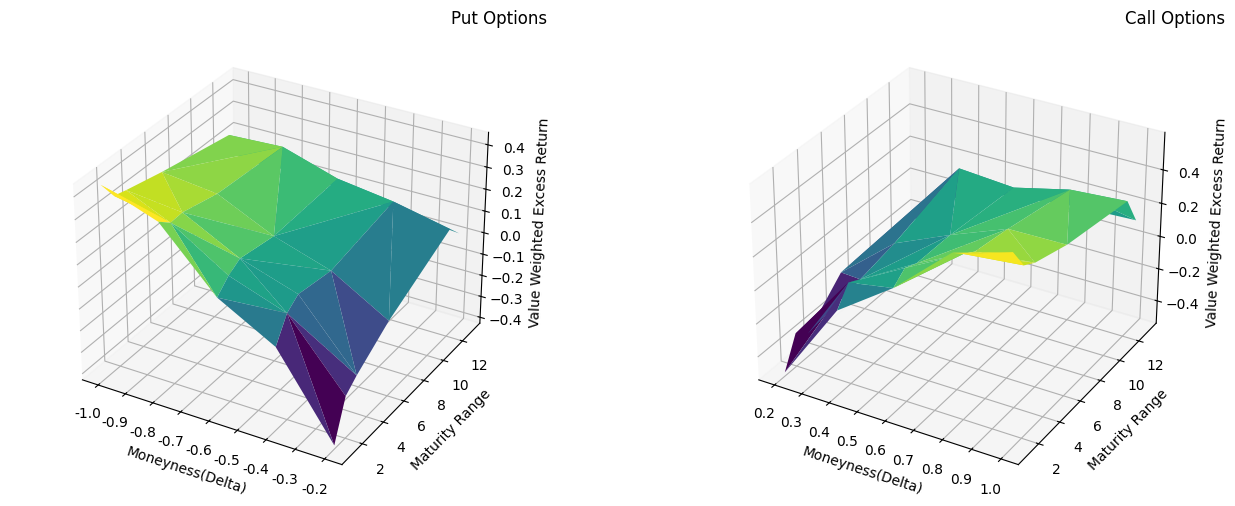

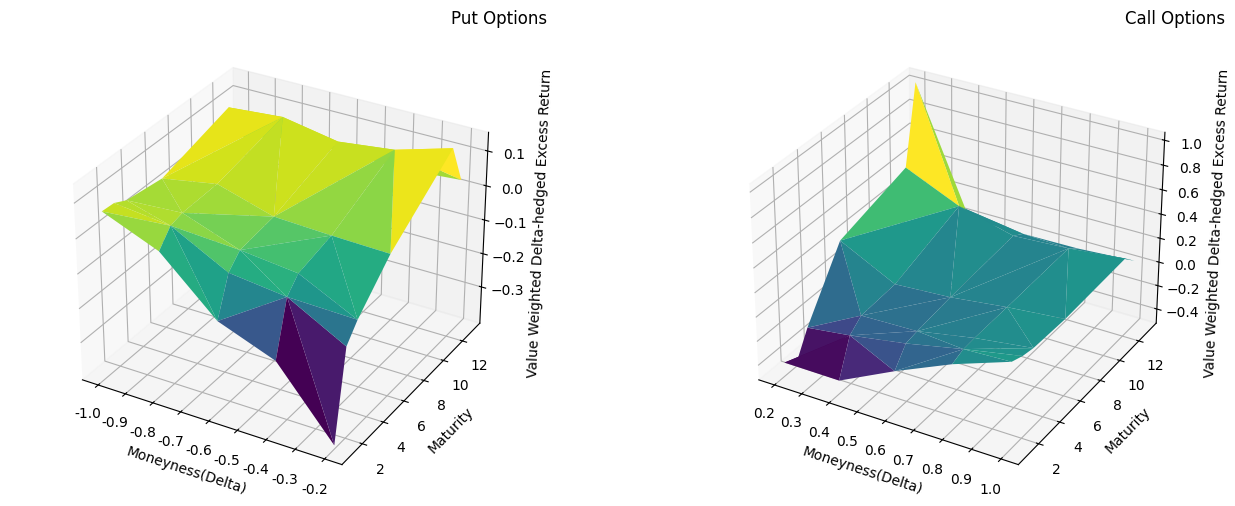

In [ ]:
##################################################################
# step4.3: visualize Value Weighted Excess Return Surface
#          and Value Weighted Delta-hedged Excess Return Surface
#          of each moneyness-maturity portfolio
##################################################################

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

# load data
result_df = pd.read_csv('mean and t stat.csv')

# create two 3-dimension figures
fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})

# Call Options
surf2 = axs[1].plot_trisurf(result_df[result_df['delta_range'] > 0]['delta_range'],
                            result_df[result_df['delta_range'] > 0]['maturity_range'],
                            result_df[result_df['delta_range'] > 0]['exret_mean'],
                            cmap='viridis', edgecolor='none')
axs[1].set_title('                                                                                    Call Options')
axs[1].set_xlabel('Moneyness(Delta)')
axs[1].set_ylabel('Maturity Range')
axs[1].set_zlabel('Value Weighted Excess Return')

# Put Options
surf1 = axs[0].plot_trisurf(result_df[result_df['delta_range'] < 0]['delta_range'],
                            result_df[result_df['delta_range'] < 0]['maturity_range'],
                            result_df[result_df['delta_range'] < 0]['exret_mean'],
                            cmap='viridis', edgecolor='none')
axs[0].set_title('                                                                                    Put Options')
axs[0].set_xlabel('Moneyness(Delta)')
axs[0].set_ylabel('Maturity Range')
axs[0].set_zlabel('Value Weighted Excess Return')

def format_func(value, tick_number):
    return "{:.1f}".format(value)

for ax in axs:
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))

# save to SVG
plt.savefig('excess_return_surface_split.svg', format='svg', bbox_inches='tight')

plt.show()


# create two 3-dimension figures
fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})

# Call Options
surf2 = axs[1].plot_trisurf(result_df[result_df['delta_range'] > 0]['delta_range'],
                            result_df[result_df['delta_range'] > 0]['maturity_range'],
                            result_df[result_df['delta_range'] > 0]['deltahedge_exret_mean'],
                            cmap='viridis', edgecolor='none')
axs[1].set_title('                                                                                    Call Options')
axs[1].set_xlabel('Moneyness(Delta)')
axs[1].set_ylabel('Maturity')
axs[1].set_zlabel('Value Weighted Delta-hedged Excess Return')

# Put Options
surf1 = axs[0].plot_trisurf(result_df[result_df['delta_range'] < 0]['delta_range'],
                            result_df[result_df['delta_range'] < 0]['maturity_range'],
                            result_df[result_df['delta_range'] < 0]['deltahedge_exret_mean'],
                            cmap='viridis', edgecolor='none')
axs[0].set_title('                                                                                    Put Options')
axs[0].set_xlabel('Moneyness(Delta)')
axs[0].set_ylabel('Maturity')
axs[0].set_zlabel('Value Weighted Delta-hedged Excess Return')

def format_func(value, tick_number):
    return "{:.1f}".format(value)

for ax in axs:
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))

# save to SVG
plt.savefig('delta_hedged_excess_return_surface_split.svg', format='svg', bbox_inches='tight')

plt.show()

In [ ]:
##################################################################
# step4.4: calculate the Momentum factor(return)
##################################################################

# load stock data
df_monthlystock_merged = pd.read_csv('monthlystock_mergeff3.csv')
df_monthlystock_merged['date'] = pd.to_datetime(df_monthlystock_merged['date'])

# loop each date
grouped = df_monthlystock_merged.groupby('date')

# the function to calculate Momentum return
def calculate_mom_ret(group):
    sorted_returns = group['monthlyreturn'].sort_values()
    # drop outliers
    trimmed_returns = sorted_returns.iloc[int(len(sorted_returns) * 0.01):int(len(sorted_returns) * 0.99)]
    # rank
    quantiles = pd.qcut(trimmed_returns, 3, labels=False)
    # quantiles
    weighted_mean_returns = trimmed_returns.groupby(quantiles).apply(lambda x: (x * (1 / group['stockprice'])).sum() / (1 / group['stockprice']).sum())
    # Momentum return
    mom_ret = weighted_mean_returns.max() - weighted_mean_returns.min()
    return mom_ret


# calculate Momentum return in each date
df_mom = grouped.apply(calculate_mom_ret).reset_index(name='mom_ret')
# shift Momentum return
df_mom['mom_ret_lag'] = df_mom['mom_ret'].shift()

# save
df_mom.to_csv('df_mom.csv', index=False)

print(df_mom)

          date   mom_ret  mom_ret_lag
0   1996-02-20  0.099946          NaN
1   1996-03-19  0.088503     0.099946
2   1996-04-23  0.096206     0.088503
3   1996-05-21  0.100973     0.096206
4   1996-06-25  0.108858     0.100973
..         ...       ...          ...
316 2022-10-25  0.132022     0.105699
317 2022-11-22  0.118491     0.132022
318 2022-12-20  0.139001     0.118491
319 2023-01-24  0.174586     0.139001
320 2023-02-21  0.095643     0.174586

[321 rows x 3 columns]


/tmp/20261329.1.jupyterhub.q/ipykernel_16079/2794388059.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mom = grouped.apply(calculate_mom_ret).reset_index(name='mom_ret')


In [ ]:
##################################################################
# step4.5: calculate the straddle factor(return)
##################################################################

from scipy.stats import norm

# load S&P 500 index option
col500 = ['date', 'symbol', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'open_interest']
df_500option = pd.read_csv('web_query_output/lubrljekpb6xsnxu.csv', usecols=col500)
df_500option['date'] = pd.to_datetime(df_500option['date'])

# strike price
df_500option['strike_price'] = df_500option['strike_price'] / 1000

# compute option 'price'
df_500option['price'] = (df_500option['best_bid'] + df_500option['best_offer']) / 2

# drop the rows which are lower than minimum bid-ask spread size
condition1 = (df_500option['price'] <= 3) & ((df_500option['best_offer'] - df_500option['best_bid']) < 0.05)
condition2 = (df_500option['price'] > 3) & ((df_500option['best_offer'] - df_500option['best_bid']) < 0.10)
df_500option = df_500option[~(condition1 | condition2)]

# drop 'best_bid', 'best_offer'
df_500option.drop(columns=['best_bid', 'best_offer'], inplace=True)

# compute 'maturity'
df_500option['maturity'] = (pd.to_datetime(df_500option['exdate']) - pd.to_datetime(df_500option['date'])).dt.days

# drop 'exdate'
df_500option.drop(columns=['exdate'], inplace=True)

df_500option['market_value'] = df_500option['price'] * df_500option['open_interest']

# sub dataframe only include call options
df_500option_C = df_500option[df_500option['cp_flag'] == 'C']
# 'price_C'
df_500option_C.rename(columns={'price': 'price_C'}, inplace=True)
df_500option_C.rename(columns={'open_interest': 'open_interest_C'}, inplace=True)
# return of each call option
df_500option_C['ret_C'] = df_500option_C.groupby('symbol')['price_C'].pct_change()
# drop columns=['symbol', 'cp_flag']
df_500option_C.drop(columns=['symbol', 'cp_flag'], inplace=True)

# sub dataframe only include put options
df_500option_P = df_500option[df_500option['cp_flag'] == 'P']
# 'price_P'
df_500option_P.rename(columns={'price': 'price_P'}, inplace=True)
df_500option_P.rename(columns={'open_interest': 'open_interest_P'}, inplace=True)
# return of each put option
df_500option_P['ret_P'] = df_500option_P.groupby('symbol')['price_P'].pct_change()
# drop columns=['symbol', 'cp_flag']
df_500option_P.drop(columns=['symbol', 'cp_flag'], inplace=True)

# merge with VIX data
df_VIX = pd.read_csv('web_query_output/b6qhp1kprabuucvs.csv')
df_VIX['Date'] = pd.to_datetime(df_VIX['Date'])
df_VIX['vix'] = df_VIX['vix'] / 100
df_500option_C_VIX = pd.merge(df_500option_C, df_VIX, left_on='date', right_on='Date', how='inner')
df_500option_C_VIX.drop(columns=['Date'], inplace=True)

# merge with S&P 500 data
# caldt(date)    vwretd(value weighted ret)    vwretx(value weighted ret without dividend)   spindx(level)
df_500 = pd.read_csv('web_query_output/latfgk3ea2uspaaf.csv')
df_500['caldt'] = pd.to_datetime(df_500['caldt'])
df_500['divid_500'] = df_500['vwretd'] - df_500['vwretx']
df_500.drop(columns=['vwretd', 'vwretx'], inplace=True)
df_500option_C_VIX_500 = pd.merge(df_500option_C_VIX, df_500, left_on='date', right_on='caldt', how='inner')
df_500option_C_VIX_500.drop(columns=['caldt'], inplace=True)
# select At-the-money options
df_500option_C_VIX_500 = df_500option_C_VIX_500[(df_500option_C_VIX_500['spindx'] / df_500option_C_VIX_500['strike_price'] > 0.99) & (df_500option_C_VIX_500['spindx'] / df_500option_C_VIX_500['strike_price'] < 1.01)]

# merge with RF data
coldateRF = ['date', 'RF']
df_RF = pd.read_csv('ff3daily.csv', usecols=coldateRF)
df_RF['date'] = pd.to_datetime(df_RF['date'])
df_500option_C_VIX_500_RF = pd.merge(df_500option_C_VIX_500, df_RF, on=['date'], how='inner')
df_500option_C_VIX_500_RF['RF'] = df_500option_C_VIX_500_RF['RF'] / 100

# d1
S = df_500option_C_VIX_500_RF['spindx']  # S&P500 index level
K = df_500option_C_VIX_500_RF['strike_price']
r = df_500option_C_VIX_500_RF['RF']
d = df_500option_C_VIX_500_RF['divid_500']  # dividend yield
sigma = df_500option_C_VIX_500_RF['vix']  # VIX index
T = df_500option_C_VIX_500_RF['maturity']
df_500option_C_VIX_500_RF['d1'] = (np.log(S / K) + (r - d + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))

# N(d1)
df_500option_C_VIX_500_RF['Nd1'] = norm.cdf(df_500option_C_VIX_500_RF['d1'])

# call options beta
df_500option_C_VIX_500_RF['beta_C'] = df_500option_C_VIX_500_RF['spindx'] / df_500option_C_VIX_500_RF['price_C'] * df_500option_C_VIX_500_RF['Nd1']

# merge call with put options
df_daily_straddle_ret = pd.merge(df_500option_C_VIX_500_RF, df_500option_P, on=['date', 'strike_price', 'maturity'], how='inner')

df_daily_straddle_ret['weight_C'] = (- df_daily_straddle_ret['price_C'] * df_daily_straddle_ret['beta_C'] + df_daily_straddle_ret['spindx']) / (df_daily_straddle_ret['price_P'] * df_daily_straddle_ret['beta_C'] - df_daily_straddle_ret['price_C'] * df_daily_straddle_ret['beta_C'] + df_daily_straddle_ret['spindx'])
df_daily_straddle_ret['weight_P'] = df_daily_straddle_ret['price_P'] * df_daily_straddle_ret['beta_C'] / (df_daily_straddle_ret['price_P'] * df_daily_straddle_ret['beta_C'] - df_daily_straddle_ret['price_C'] * df_daily_straddle_ret['beta_C'] + df_daily_straddle_ret['spindx'])

# calculate the straddle return
df_daily_straddle_ret['ret_straddle'] = df_daily_straddle_ret['weight_C'] * (df_daily_straddle_ret['ret_C'] - df_daily_straddle_ret['RF']) + df_daily_straddle_ret['weight_P'] * (df_daily_straddle_ret['ret_P'] - df_daily_straddle_ret['RF'])

# drop NAN
df_daily_straddle_ret.dropna(subset=['ret_straddle'], inplace=True)

# average straddle returns

grouped_df = df_daily_straddle_ret.groupby('date')['ret_straddle'].agg(ret_straddle_mean='mean').reset_index()
grouped_df['R_straddle'] = grouped_df['ret_straddle_mean'] + 1

# prepare a dataframe
df_straddle = pd.DataFrame(columns=['date', 'straddle_ret'])

# loop rblist to cumulate daily straddle returns to monthly
for i in range(len(rblist) - 1):
    start_date = rblist[i]
    end_date = rblist[i+1]
    # each month
    df_period = grouped_df[(grouped_df['date'] >= start_date) & (grouped_df['date'] <= end_date)]
    # cumlative monthly straddle return
    month_ret_straddle = df_period['R_straddle'].prod() - 1
    # save
    df_straddle = pd.concat([df_straddle, pd.DataFrame({'date': [end_date], 'straddle_ret': [month_ret_straddle]})], ignore_index=True)

# save
df_straddle.to_csv('df_straddle.csv', index=False)

print(df_straddle)

# merge with Fama-French 3 factors, momentum factors and straddle factors
col = ['End Date', 'Mkt', 'SMB', 'HML', 'RF']
df_ff3 = pd.read_csv('monthlyff3.csv', usecols=col)
df_ff3['End Date'] = pd.to_datetime(df_ff3['End Date'])
df_ff3.rename(columns={'End Date': 'date'}, inplace=True)
df_exret = pd.read_csv('df_exret.csv')
df_exret['date'] = pd.to_datetime(df_exret['date'])
df_exret_ff3 = pd.merge(df_exret, df_ff3, on=['date'], how='inner')
df_exret_ff4 = pd.merge(df_exret_ff3, df_straddle, on=['date'], how='inner')
df_exret_ff5 = pd.merge(df_exret_ff4, df_mom, on=['date'], how='inner')
df_exret_ff5['ex_mom'] = df_exret_ff5['mom_ret_lag'] - df_exret_ff5['RF']
df_exret_ff5.to_csv('df_exret_ff5.csv', index=False)

/tmp/20368128.1.jupyterhub.q/ipykernel_41702/2009857842.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500option_C.rename(columns={'price': 'price_C'}, inplace=True)
/tmp/20368128.1.jupyterhub.q/ipykernel_41702/2009857842.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500option_C.rename(columns={'open_interest': 'open_interest_C'}, inplace=True)
/tmp/20368128.1.jupyterhub.q/ipykernel_41702/2009857842.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

          date  straddle_ret
0   1996-02-20      0.492259
1   1996-03-19      1.156654
2   1996-04-23     -0.097529
3   1996-05-21     -0.200867
4   1996-06-25     -0.087892
..         ...           ...
320 2022-10-25      0.669683
321 2022-11-22     -0.145249
322 2022-12-20      0.722895
323 2023-01-24     -0.218683
324 2023-02-21      0.467037

[325 rows x 2 columns]


In [ ]:
# load data
df_exret_ff5 = pd.read_csv('df_exret_ff5.csv')
df_exret_ff5['date'] = pd.to_datetime(df_exret_ff5['date'])

In [ ]:
##################################################################
# step4.6: run the regression of 60 maturity-moneyness portfolios
##################################################################



def get_regression_results(X, y, maxlags=2):
    """Perform OLS regression with Newey-West standard errors."""
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})
    return results.params, results.tvalues

def process_data(df, output_filename, delta_column):
    """Apply regression and calculate expected returns for a given DataFrame."""
    X_vars = [
        ['Mkt', 'SMB', 'HML'],
        ['Mkt', 'SMB', 'HML', 'ex_mom'],
        ['Mkt', 'SMB', 'HML', 'ex_mom', 'straddle_ret'],
        ['Mkt']
    ]

    y = df[delta_column]
    mean_y = y.mean()

    results = {}
    for i, X_var in enumerate(X_vars, 1):
        X = df[X_var]
        coefficients, t_values = get_regression_results(X, y)
        results.update({
            f'coef_const_{i}': coefficients.get('const'),
            f't_const_{i}': t_values.get('const'),
            f'coef_Mkt_{i}': coefficients.get('Mkt'),
            f't_Mkt_{i}': t_values.get('Mkt'),
        })
        if 'SMB' in X_var:
            results.update({
                f'coef_SMB_{i}': coefficients.get('SMB'),
                f't_SMB_{i}': t_values.get('SMB'),
                f'coef_HML_{i}': coefficients.get('HML'),
                f't_HML_{i}': t_values.get('HML'),
            })
        if 'ex_mom' in X_var:
            results.update({
                f'coef_ex_mom_{i}': coefficients.get('ex_mom'),
                f't_ex_mom_{i}': t_values.get('ex_mom'),
            })
        if 'straddle_ret' in X_var:
            results.update({
                f'coef_straddle_{i}': coefficients.get('straddle_ret'),
                f't_straddle_{i}': t_values.get('straddle_ret'),
            })

    results['mean_y'] = mean_y

    result_df = pd.DataFrame([results])
    result_df.to_csv(output_filename, index=False)


# Process the data
process_data(df_exret_ff5, 'nogroup_delta_exret_ols.csv', 'valueweight_deltahedge_exret')

process_data(df_exret_ff5, 'nogroup_delta_exret_ols_moneyness.csv', 'valueweight_deltahedge_exret')

In [ ]:

def get_regression_results(X, y, maxlags=2):
    """Perform OLS regression with Newey-West standard errors."""
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})
    return results.params, results.tvalues

def process_data(df, output_filename, delta_column, group):
    """Apply regression and calculate expected returns for a given DataFrame."""
    X_vars = [
        ['Mkt', 'SMB', 'HML'],
        ['Mkt', 'SMB', 'HML', 'ex_mom'],
        ['Mkt', 'SMB', 'HML', 'ex_mom', 'straddle_ret'],
        ['Mkt']
    ]

    mean_y = df[delta_column].mean()

    # Group by 'maturity_range' and 'delta_range'
    grouped = df.groupby(group)

    results = []
    for group_name, group_data in grouped:
        y = group_data[delta_column]
        results_group = {'maturity_range': group_name[0], 'delta_range': group_name[1]}

        for i, X_var in enumerate(X_vars, 1):
            X = group_data[X_var]
            coefficients, t_values = get_regression_results(X, y)
            results_group.update({
                f'coef_const_{i}': coefficients.get('const'),
                f't_const_{i}': t_values.get('const'),
                f'coef_Mkt_{i}': coefficients.get('Mkt'),
                f't_Mkt_{i}': t_values.get('Mkt'),
            })
            if 'SMB' in X_var:
                results_group.update({
                    f'coef_SMB_{i}': coefficients.get('SMB'),
                    f't_SMB_{i}': t_values.get('SMB'),
                    f'coef_HML_{i}': coefficients.get('HML'),
                    f't_HML_{i}': t_values.get('HML'),
                })
            if 'ex_mom' in X_var:
                results_group.update({
                    f'coef_ex_mom_{i}': coefficients.get('ex_mom'),
                    f't_ex_mom_{i}': t_values.get('ex_mom'),
                })
            if 'straddle_ret' in X_var:
                results_group.update({
                    f'coef_straddle_{i}': coefficients.get('straddle_ret'),
                    f't_straddle_{i}': t_values.get('straddle_ret'),
                })

        results_group['mean_y'] = mean_y
        results.append(results_group)

    result_df = pd.DataFrame(results)
    result_df.to_csv(output_filename, index=False)


# Process the data
process_data(df_exret_ff5, 'delta_exret_ols.csv', 'valueweight_deltahedge_exret', ['maturity_range', 'delta_range'])

#process_data(df_exret_ff5, 'delta_exret_ols_moneyness.csv', 'valueweight_deltahedge_exret', ['delta_range'])

#process_data(df_exret_ff5, 'delta_exret_ols_maturity.csv', 'valueweight_deltahedge_exret', ['maturity_range'])

process_data(df_exret_ff5, 'exret_ols.csv', 'valueweight_exret', ['maturity_range', 'delta_range'])

#process_data(df_exret_ff5, 'exret_ols_moneyness.csv', 'valueweight_exret', ['delta_range'])

#process_data(df_exret_ff5, 'exret_ols_maturity.csv', 'valueweight_exret', ['maturity_range'])

In [ ]:
# load data
df_monthlyoption_merge = pd.read_csv('monthlyoption_merge.csv')
df_monthlyoption_merge['date'] = pd.to_datetime(df_monthlyoption_merge['date'])


In [ ]:
##################################################################
# step5.1: construct BAB portfolios - by option's betas
##################################################################

# optionbeta.shift()
df_monthlyoption_merge['optionbeta_lag'] = df_monthlyoption_merge.groupby('symbol')['optionbeta'].shift()
# drop NAN
df_monthlyoption_merge.dropna(subset=['optionbeta_lag'], inplace=True)
# weight = 1 / optionbeta, opbeta_exret = option beta weighted excess return of each option
df_monthlyoption_merge['opbeta_exret'] = 1 / df_monthlyoption_merge['optionbeta_lag'] * df_monthlyoption_merge['each_option_excessreturn']
# opbeta_delta_exret = option beta weighted delta-hedged excess return of each option
df_monthlyoption_merge['opbeta_delta_exret'] = 1 / df_monthlyoption_merge['optionbeta_lag'] * df_monthlyoption_merge['each_deltahedge_excessreturn']

# drop outliers
df_monthlyoption_merge.sort_values(by='optionbeta', key=abs, inplace=True)
rows_to_delete = int(len(df_monthlyoption_merge) * 0.01)
df_monthlyoption_merge = df_monthlyoption_merge.iloc[rows_to_delete:-rows_to_delete].copy()
df_monthlyoption_merge = df_monthlyoption_merge[(df_monthlyoption_merge['delta'] >= -0.99) & (df_monthlyoption_merge['delta'] <= 0.99)]
df_monthlyoption_merge = df_monthlyoption_merge[(df_monthlyoption_merge['delta'] <= -0.01) | (df_monthlyoption_merge['delta'] >= 0.01)]



# groupby day_diff_range, delta_ranges
def calculate_BAB_opbeta(group, day_diff_range, delta_ranges):
    df_BAB_opbeta_list = []

    for day_range in day_diff_range:
        for delta_value in delta_ranges:
            df_filtered = group[(group['maturity'] >= day_range[0]) &
                                (group['maturity'] < day_range[1]) &
                                (group['delta'] >= delta_value[0]) &
                                (group['delta'] < delta_value[1])]

            if not df_filtered.empty:
                # rank by 'optionbeta_lag'
                df_filtered_sorted = df_filtered.sort_values(by='optionbeta_lag', ascending=False)

                # larger 10% to 40%
                bottom_10_percent = df_filtered_sorted['optionbeta_lag'].quantile(0.1)
                top_40_percent = df_filtered_sorted['optionbeta_lag'].quantile(0.4)
                # smaller
                bottom_60_percent = df_filtered_sorted['optionbeta_lag'].quantile(0.6)
                top_90_percent = df_filtered_sorted['optionbeta_lag'].quantile(0.9)

                filtered_data_1 = df_filtered_sorted[
                    (df_filtered_sorted['optionbeta_lag'] >= bottom_10_percent) &
                    (df_filtered_sorted['optionbeta_lag'] <= top_40_percent)
                ]
                filtered_data_2 = df_filtered_sorted[
                    (df_filtered_sorted['optionbeta_lag'] >= bottom_60_percent) &
                    (df_filtered_sorted['optionbeta_lag'] <= top_90_percent)
                ]

                mean_value_1 = filtered_data_1['opbeta_exret'].mean()
                mean_value_2 = filtered_data_2['opbeta_exret'].mean()

                # BAB_opbeta
                BAB_opbeta_exret = mean_value_2 - mean_value_1

                mean_value_11 = filtered_data_1['opbeta_delta_exret'].mean()
                mean_value_22 = filtered_data_2['opbeta_delta_exret'].mean()

                BAB_opbeta_delta_exret = mean_value_22 - mean_value_11

                df_BAB_opbeta_list.append({'date': df_filtered.iloc[0]['date'],
                                           'maturity_range': day_range,
                                           'delta_range': delta_value,
                                           'BAB_opbeta_exret': BAB_opbeta_exret,
                                           'BAB_opbeta_delta_exret': BAB_opbeta_delta_exret})

    return pd.DataFrame(df_BAB_opbeta_list)


# 6 maturites
day_diff_range = [(0, 35), (35, 63), (63, 91), (91, 182), (182, 366), (366, 9999)]

# 10 moneynesses
delta_ranges = [(-1.0, -0.8), (-0.8, -0.6), (-0.6, -0.4), (-0.4, -0.2), (-0.2, 0),
                (0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]

# 按照'date'分组，并对每个组应用calculate_BAB_opbeta函数
df_BAB_opbeta = df_monthlyoption_merge.groupby('date').apply(calculate_BAB_opbeta, day_diff_range, delta_ranges)


df_BAB_opbeta.to_csv('df_BAB_opbeta.csv', index=False)

print(df_BAB_opbeta)

In [ ]:
##################################################################
# step5.2: Fama-Macbeth regression Y = BAB portfolios - by option's betas
##################################################################

# load data
df_BAB_opbeta = pd.read_csv('df_BAB_opbeta.csv')
df_BAB_opbeta['date'] = pd.to_datetime(df_BAB_opbeta['date'])

# fill NaN by 0
df_BAB_opbeta['BAB_opbeta_exret'].fillna(0, inplace=True)
df_BAB_opbeta['BAB_opbeta_delta_exret'].fillna(0, inplace=True)

# merge with Fama-French 3 factors, momentum factors and straddle factors
df_ff3 = pd.read_csv('monthlyff3.csv')
df_ff3['date'] = pd.to_datetime(df_ff3['date'])
df_BAB_opbeta_ff3 = pd.merge(df_BAB_opbeta, df_ff3, on=['date'], how='inner')

df_straddle = pd.read_csv('df_straddle.csv')
df_straddle['date'] = pd.to_datetime(df_straddle['date'])
df_BAB_opbeta_ff4 = pd.merge(df_BAB_opbeta_ff3, df_straddle, on=['date'], how='inner')

df_mom = pd.read_csv('df_mom.csv')
df_mom = df_mom.dropna()
df_mom['date'] = pd.to_datetime(df_mom['date'])

df_BAB_opbeta_ff5 = pd.merge(df_BAB_opbeta_ff4, df_mom, on=['date'], how='inner')
df_BAB_opbeta_ff5['ex_mom'] = df_BAB_opbeta_ff5['mom_ret_lag'] - df_BAB_opbeta_ff5['RF']


def replace_delta_range(value):
    range_mapping = {
        '(-1.0, -0.8)': -1.0,
        '(-0.8, -0.6)': -0.8,
        '(-0.6, -0.4)': -0.6,
        '(-0.4, -0.2)': -0.4,
        '(-0.2, 0)': -0.2,
        '(0.8, 1.0)': 1.0,
        '(0.6, 0.8)': 0.8,
        '(0.4, 0.6)': 0.6,
        '(0.2, 0.4)': 0.4,
        '(0, 0.2)': 0.2
    }
    if value in range_mapping:
        return range_mapping[value]
    else:
        return value

# replace 'delta_range'
df_BAB_opbeta_ff5['delta_range'] = df_BAB_opbeta_ff5['delta_range'].apply(replace_delta_range)

maturity_range_mapping = {
    '(0, 35)': 1,
    '(35, 63)': 2,
    '(63, 91)': 3,
    '(91, 182)': 6,
    '(182, 366)': 12,
    '(366, 9999)': 13
}

# replace 'maturity_range'
df_BAB_opbeta_ff5['maturity_range'] = df_BAB_opbeta_ff5['maturity_range'].map(maturity_range_mapping)

df_BAB_opbeta_ff5.to_csv('df_BAB_opbeta_ff5.csv', index=False)

print(df_BAB_opbeta_ff5)

In [ ]:
# load data
df_BAB_opbeta_ff5 = pd.read_csv('df_BAB_opbeta_ff5.csv')
df_BAB_opbeta_ff5['date'] = pd.to_datetime(df_BAB_opbeta_ff5['date'])



def get_regression_results(X, y, maxlags=2):
    """Perform OLS regression with Newey-West standard errors."""
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})
    return results.params, results.tvalues

def process_data(df, output_filename, delta_column):
    """Apply regression and calculate expected returns for a given DataFrame."""
    X_vars = [
        ['Mkt', 'SMB', 'HML'],
        ['Mkt', 'SMB', 'HML', 'ex_mom'],
        ['Mkt', 'SMB', 'HML', 'ex_mom', 'straddle_ret'],
        ['Mkt']
    ]

    y = df[delta_column]
    mean_y = y.mean()

    results = {}
    for i, X_var in enumerate(X_vars, 1):
        X = df[X_var]
        coefficients, t_values = get_regression_results(X, y)
        results.update({
            f'coef_const_{i}': coefficients.get('const'),
            f't_const_{i}': t_values.get('const'),
            f'coef_Mkt_{i}': coefficients.get('Mkt'),
            f't_Mkt_{i}': t_values.get('Mkt'),
        })
        if 'SMB' in X_var:
            results.update({
                f'coef_SMB_{i}': coefficients.get('SMB'),
                f't_SMB_{i}': t_values.get('SMB'),
                f'coef_HML_{i}': coefficients.get('HML'),
                f't_HML_{i}': t_values.get('HML'),
            })
        if 'ex_mom' in X_var:
            results.update({
                f'coef_ex_mom_{i}': coefficients.get('ex_mom'),
                f't_ex_mom_{i}': t_values.get('ex_mom'),
            })
        if 'straddle_ret' in X_var:
            results.update({
                f'coef_straddle_{i}': coefficients.get('straddle_ret'),
                f't_straddle_{i}': t_values.get('straddle_ret'),
            })

    results['mean_y'] = mean_y

    result_df = pd.DataFrame([results])
    result_df.to_csv(output_filename, index=False)


# Process the data
process_data(df_BAB_opbeta_ff5, 'ols_df_BAB_opbeta_ff5.csv', 'BAB_opbeta_exret')

process_data(df_BAB_opbeta_ff5, 'ols_df_BAB_delta_opbeta_ff5.csv', 'BAB_opbeta_delta_exret')


In [ ]:
##################################################################
# step5.3: vix betas of underlying stock
##################################################################

# load stock data
df_monthlystock_merged = pd.read_csv('monthlystock_mergeff3.csv')
df_monthlystock_merged['date'] = pd.to_datetime(df_monthlystock_merged['date'])

# merge with VIX data
df_VIX = pd.read_csv('web_query_output/psjsjgg04vfvitkp.csv')
df_VIX['Date'] = pd.to_datetime(df_VIX['Date'])
df_VIX = df_VIX[df_VIX['Date'].isin(rblist)]
df_VIX = df_VIX.drop_duplicates(subset=['Date'])
df_VIX = df_VIX.reset_index(drop=True)
df_VIX['vix'] = df_VIX['vix'] / 100
df_VIX['vix_lag'] = df_VIX['vix'].shift()
df_VIX['vix_diff'] = df_VIX['vix'].diff()
df_VIX = df_VIX.dropna()
df_stock_VIX = pd.merge(df_monthlystock_merged, df_VIX, left_on='date', right_on='Date', how='inner')


# prepare a dataframe for stock betas
results = []

# regress by 'PERMNO'groups
for permno, group in df_stock_VIX.groupby('PERMNO'):

    # denote Y and Xs
    X1 = np.array(group[['Mkt', 'vix_lag']])
    X2 = np.array(group[['Mkt', 'vix_diff']])
    y = np.array(group['excessret']).reshape(-1, 1)

    # CAPM
    model_X1 = LinearRegression()
    model_X1.fit(X1, y)
    slope_X1_mkt = model_X1.coef_[0][0]
    slope_X1_vixlag = model_X1.coef_[0][1]

    # Fama-French 3 factors
    model_X2 = LinearRegression()
    model_X2.fit(X2, y)
    slope_X2_mkt = model_X2.coef_[0][0]
    slope_X2_vixdiff = model_X2.coef_[0][1]

    # regression result
    results.append({
        'PERMNO': permno,
        'Beta_vixlag': slope_X1_vixlag,
        'Beta_vixdiff': slope_X2_vixdiff
    })

# save betas
df_vixbetas = pd.DataFrame(results)

# save stock vix betas to a csv
df_vixbetas.to_csv('vixbetas.csv', index=False)

# merge with VIX data
df_monthlyoption_merge = pd.read_csv('monthlyoption_merge.csv')
df_monthlyoption_merge['date'] = pd.to_datetime(df_monthlyoption_merge['date'])
df_monthlyoption_merge['strike_price'] = df_monthlyoption_merge['strike_price'] / 1000
df_monthlyoption_merge['KS'] = df_monthlyoption_merge['strike_price'] / df_monthlyoption_merge['stockprice']
df_option_VIX = pd.merge(df_monthlyoption_merge, df_VIX, left_on='date', right_on='Date', how='inner')
df_option_VIX.drop(columns=['Date'], inplace=True)

df_option_VIX.to_csv('df_option_VIX_ff5.csv', index=False)
df_option_VIX_ff5 = pd.read_csv('df_option_VIX_ff5.csv')
df_option_VIX_ff5['date'] = pd.to_datetime(df_option_VIX_ff5['date'])

df_option_VIX_ff5 = pd.merge(df_option_VIX_ff5, df_vixbetas, on=['PERMNO'], how='inner')

# option vix betas
df_option_VIX_ff5['opvixbeta_lag'] = df_option_VIX_ff5['stockprice'] / df_option_VIX_ff5['price'] * df_option_VIX_ff5['delta'] * df_option_VIX_ff5['Beta_vixlag']
df_option_VIX_ff5['opvixbeta_diff'] = df_option_VIX_ff5['stockprice'] / df_option_VIX_ff5['price'] * df_option_VIX_ff5['delta'] * df_option_VIX_ff5['Beta_vixdiff']

df_option_VIX_ff5.to_csv('df_option_VIX_ff5.csv', index=False)

In [ ]:
# statistics description
description_vix = df_option_VIX_ff5.describe()
description_vix.to_csv('summary_statistics_vix.csv')

In [ ]:
# load data
df_option_VIX_ff5 = pd.read_csv('df_option_VIX_ff5.csv')
df_option_VIX_ff5['date'] = pd.to_datetime(df_option_VIX_ff5['date'])
df_monthlyoption_merge = pd.read_csv('monthlyoption_merge.csv')
df_monthlyoption_merge['date'] = pd.to_datetime(df_monthlyoption_merge['date'])

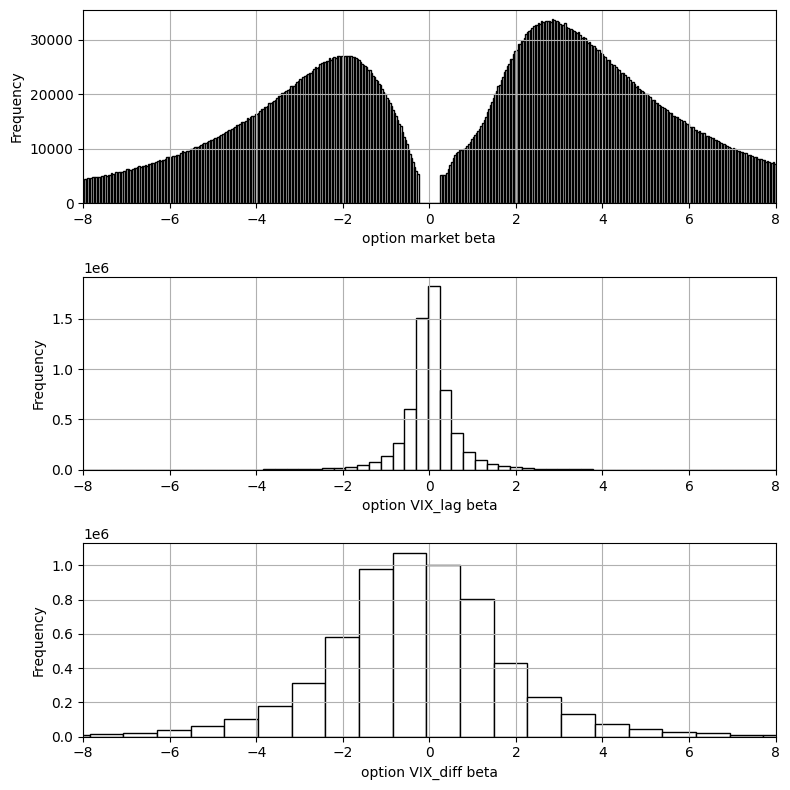

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# subplot: option market beta
axs[0].hist(df_monthlyoption_merge['optionbeta'], bins=1000, color='white', edgecolor='black')
axs[0].set_xlabel('Option market beta')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)
axs[0].set_xlim(-8, 8)

# subplot: option VIX_lag beta
axs[1].hist(df_option_VIX_ff5['opvixbeta_lag'], bins=1000, color='white', edgecolor='black')
axs[1].set_xlabel('Option VIX_lag beta')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)
axs[1].set_xlim(-8, 8)

# subplot: option VIX_diff beta
axs[2].hist(df_option_VIX_ff5['opvixbeta_diff'], bins=1000, color='white', edgecolor='black')
axs[2].set_xlabel('Option VIX_diff beta')
axs[2].set_ylabel('Frequency')
axs[2].grid(True)
axs[2].set_xlim(-8, 8)

plt.tight_layout()

# save
plt.savefig('Histograms of option betas.svg', format='svg')

plt.show()


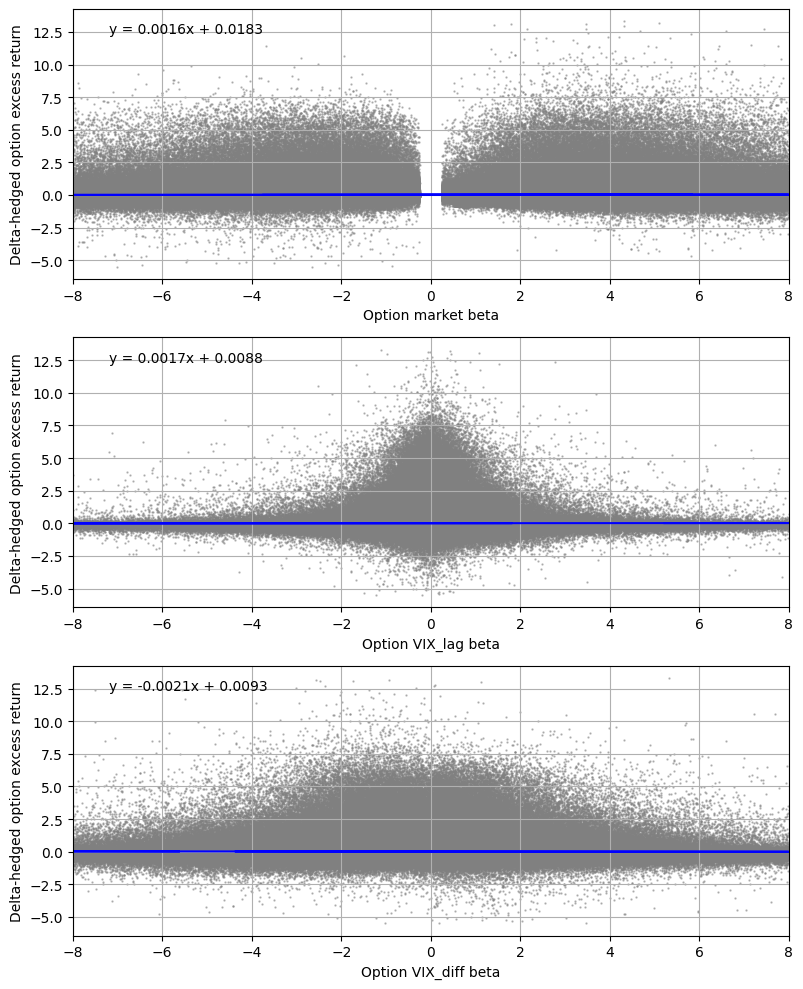

In [ ]:
# scatter plots
df_monthlyoption_merge_sample = df_monthlyoption_merge[(df_monthlyoption_merge['optionbeta'] >= -8) & (df_monthlyoption_merge['optionbeta'] <= 8)]
df_option_VIX_ff5_sample_1 = df_option_VIX_ff5[(df_option_VIX_ff5['opvixbeta_lag'] >= -8) & (df_option_VIX_ff5['opvixbeta_lag'] <= 8)]
df_option_VIX_ff5_sample_2 = df_option_VIX_ff5[(df_option_VIX_ff5['opvixbeta_diff'] >= -8) & (df_option_VIX_ff5['opvixbeta_diff'] <= 8)]

x1 = df_monthlyoption_merge_sample['optionbeta']
y1 = df_monthlyoption_merge_sample['each_deltahedge_excessreturn']
x2 = df_option_VIX_ff5_sample_1['opvixbeta_lag']
y2 = df_option_VIX_ff5_sample_1['each_deltahedge_excessreturn']
x3 = df_option_VIX_ff5_sample_2['opvixbeta_diff']
y3 = df_option_VIX_ff5_sample_2['each_deltahedge_excessreturn']

fig, axs = plt.subplots(3, 1, figsize=(8, 10))

point_color = '#808080'
point_size = 0.5
point_alpha = 0.5

axs[0].scatter(x1, y1, color=point_color, s=point_size, alpha=point_alpha)
slope1, intercept1 = np.polyfit(x1, y1, 1)
axs[0].plot(x1, slope1 * x1 + intercept1, color='blue')
axs[0].set_xlabel('Option market beta')
axs[0].set_ylabel('Delta-hedged option excess return')
axs[0].grid(True)
axs[0].set_xlim(-8, 8)
equation1 = f'y = {slope1:.4f}x + {intercept1:.4f}'
axs[0].text(0.05, 0.95, equation1, transform=axs[0].transAxes, fontsize=10, verticalalignment='top')

axs[1].scatter(x2, y2, color=point_color, s=point_size, alpha=point_alpha)
slope2, intercept2 = np.polyfit(x2, y2, 1)
axs[1].plot(x2, slope2 * x2 + intercept2, color='blue')
axs[1].set_xlabel('Option VIX_lag beta')
axs[1].set_ylabel('Delta-hedged option excess return')
axs[1].grid(True)
axs[1].set_xlim(-8, 8)
equation2 = f'y = {slope2:.4f}x + {intercept2:.4f}'
axs[1].text(0.05, 0.95, equation2, transform=axs[1].transAxes, fontsize=10, verticalalignment='top')

axs[2].scatter(x3, y3, color=point_color, s=point_size, alpha=point_alpha)
slope3, intercept3 = np.polyfit(x3, y3, 1)
axs[2].plot(x3, slope3 * x3 + intercept3, color='blue')
axs[2].set_xlabel('Option VIX_diff beta')
axs[2].set_ylabel('Delta-hedged option excess return')
axs[2].grid(True)
axs[2].set_xlim(-8, 8)
equation3 = f'y = {slope3:.4f}x + {intercept3:.4f}'
axs[2].text(0.05, 0.95, equation3, transform=axs[2].transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()

# save
plt.savefig('Scatter plots of option betas.png', format='png')

plt.show()

In [ ]:
##################################################################
# step5.4: BAB postfolios of vix betas
##################################################################

# optionbeta.shift()
df_option_VIX_ff5['opvixbeta_lag_shift'] = df_option_VIX_ff5.groupby('symbol')['opvixbeta_lag'].shift()
df_option_VIX_ff5['opvixbeta_diff_shift'] = df_option_VIX_ff5.groupby('symbol')['opvixbeta_diff'].shift()

# drop NAN
df_option_VIX_ff5.dropna(subset=['opvixbeta_lag_shift'], inplace=True)
df_option_VIX_ff5.dropna(subset=['opvixbeta_diff_shift'], inplace=True)

df_option_VIX_ff5['vixbeta_lag_exret'] = 1 / df_option_VIX_ff5['opvixbeta_lag_shift'] * df_option_VIX_ff5['each_option_excessreturn']
df_option_VIX_ff5['vixbeta_lag_delta_exret'] = 1 / df_option_VIX_ff5['opvixbeta_lag_shift'] * df_option_VIX_ff5['each_deltahedge_excessreturn']

df_option_VIX_ff5['vixbeta_diff_exret'] = 1 / df_option_VIX_ff5['opvixbeta_diff_shift'] * df_option_VIX_ff5['each_option_excessreturn']
df_option_VIX_ff5['vixbeta_diff_delta_exret'] = 1 / df_option_VIX_ff5['opvixbeta_diff_shift'] * df_option_VIX_ff5['each_deltahedge_excessreturn']


# groupby 'date'
def calculate_BAB_vixbeta(group, day_diff_range, delta_ranges):
    df_BAB_vixbeta_list = []

    for day_range in day_diff_range:
        for delta_value in delta_ranges:
            df_filtered = group[(group['maturity'] >= day_range[0]) &
                                (group['maturity'] < day_range[1]) &
                                (group['delta'] >= delta_value[0]) &
                                (group['delta'] < delta_value[1])]

            if not df_filtered.empty:
                # rank
                df_filtered_vixlag = df_filtered.sort_values(by='opvixbeta_lag_shift', ascending=False)

                # larger 10% to 40%
                bottom_10_percent = df_filtered_vixlag['opvixbeta_lag_shift'].quantile(0.1)
                top_40_percent = df_filtered_vixlag['opvixbeta_lag_shift'].quantile(0.4)
                # smaller
                bottom_60_percent = df_filtered_vixlag['opvixbeta_lag_shift'].quantile(0.6)
                top_90_percent = df_filtered_vixlag['opvixbeta_lag_shift'].quantile(0.9)

                filtered_data_1 = df_filtered_vixlag[
                    (df_filtered_vixlag['opvixbeta_lag_shift'] >= bottom_10_percent) &
                    (df_filtered_vixlag['opvixbeta_lag_shift'] <= top_40_percent)
                ]
                filtered_data_2 = df_filtered_vixlag[
                    (df_filtered_vixlag['opvixbeta_lag_shift'] >= bottom_60_percent) &
                    (df_filtered_vixlag['opvixbeta_lag_shift'] <= top_90_percent)
                ]

                mean_value_1 = filtered_data_1['vixbeta_lag_exret'].mean()
                mean_value_2 = filtered_data_2['vixbeta_lag_exret'].mean()

                # BAB
                BAB_vixbeta_exret = mean_value_2 - mean_value_1

                mean_value_11 = filtered_data_1['vixbeta_lag_delta_exret'].mean()
                mean_value_22 = filtered_data_2['vixbeta_lag_delta_exret'].mean()

                BAB_vixbeta_delta_exret = mean_value_22 - mean_value_11

                df_filtered_vixlag = df_filtered.sort_values(by='opvixbeta_diff_shift', ascending=False)

                bottom_10_percent = df_filtered_vixlag['opvixbeta_diff_shift'].quantile(0.1)
                top_40_percent = df_filtered_vixlag['opvixbeta_diff_shift'].quantile(0.4)
                bottom_60_percent = df_filtered_vixlag['opvixbeta_diff_shift'].quantile(0.6)
                top_90_percent = df_filtered_vixlag['opvixbeta_diff_shift'].quantile(0.9)

                filtered_data_1 = df_filtered_vixlag[
                    (df_filtered_vixlag['opvixbeta_diff_shift'] >= bottom_10_percent) &
                    (df_filtered_vixlag['opvixbeta_diff_shift'] <= top_40_percent)
                ]
                filtered_data_2 = df_filtered_vixlag[
                    (df_filtered_vixlag['opvixbeta_diff_shift'] >= bottom_60_percent) &
                    (df_filtered_vixlag['opvixbeta_diff_shift'] <= top_90_percent)
                ]

                mean_value_1 = filtered_data_1['vixbeta_diff_exret'].mean()
                mean_value_2 = filtered_data_2['vixbeta_diff_exret'].mean()

                BAB_vixbeta_exret2 = mean_value_2 - mean_value_1

                mean_value_11 = filtered_data_1['vixbeta_diff_delta_exret'].mean()
                mean_value_22 = filtered_data_2['vixbeta_diff_delta_exret'].mean()

                BAB_vixbeta_delta_exret2 = mean_value_22 - mean_value_11

                df_BAB_vixbeta_list.append({'date': df_filtered.iloc[0]['date'],
                                            'maturity_range': day_range,
                                            'delta_range': delta_value,
                                            'BAB_vixbeta_lag_exret': BAB_vixbeta_exret,
                                            'BAB_vixbeta_lag_delta_exret': BAB_vixbeta_delta_exret,
                                            'BAB_vixbeta_diff_exret': BAB_vixbeta_exret2,
                                            'BAB_vixbeta_diff_delta_exret': BAB_vixbeta_delta_exret2})

    return pd.DataFrame(df_BAB_vixbeta_list)


# 6 maturites
day_diff_range = [(0, 35), (35, 63), (63, 91), (91, 182), (182, 366), (366, 9999)]

# 10 moneynesses
delta_ranges = [(-1.0, -0.8), (-0.8, -0.6), (-0.6, -0.4), (-0.4, -0.2), (-0.2, 0),
                (0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]

# calculate BAB portfolios returns
df_BAB_opvixbeta_ff5 = df_option_VIX_ff5.groupby('date').apply(calculate_BAB_vixbeta, day_diff_range, delta_ranges)

print(df_BAB_opvixbeta_ff5)

df_BAB_opvixbeta_ff5.to_csv('df_BAB_opvixbeta_ff5.csv', index=False)

In [ ]:
# load data
df_BAB_opvixbeta_ff5 = pd.read_csv('df_BAB_opvixbeta_ff5.csv')
df_BAB_opvixbeta_ff5['date'] = pd.to_datetime(df_BAB_opvixbeta_ff5['date'])
# statistics description
description_babvix = df_BAB_opvixbeta_ff5.describe()
# Save to CSV
description_babvix.to_csv('summary_statistics_babvix.csv')


df_BAB_opbeta_ff5 = pd.read_csv('df_BAB_opbeta_ff5.csv')
df_BAB_opbeta_ff5['date'] = pd.to_datetime(df_BAB_opbeta_ff5['date'])
# statistics description
description_babop = df_BAB_opbeta_ff5.describe()
# Save to CSV
description_babop.to_csv('summary_statistics_babop.csv')

In [ ]:
##################################################################
# step5.5: Fama-Macbeth 1 first step regression Y = BAB vixbeta option returns
##################################################################

# load data
df_BAB_vixbeta_ff5 = pd.read_csv('df_BAB_opvixbeta_ff5.csv')
df_BAB_vixbeta_ff5['date'] = pd.to_datetime(df_BAB_vixbeta_ff5['date'])


def replace_delta_range(value):
    range_mapping = {
        '(-1.0, -0.8)': -1.0,
        '(-0.8, -0.6)': -0.8,
        '(-0.6, -0.4)': -0.6,
        '(-0.4, -0.2)': -0.4,
        '(-0.2, 0)': -0.2,
        '(0.8, 1.0)': 1.0,
        '(0.6, 0.8)': 0.8,
        '(0.4, 0.6)': 0.6,
        '(0.2, 0.4)': 0.4,
        '(0, 0.2)': 0.2
    }
    if value in range_mapping:
        return range_mapping[value]
    else:
        return value

# numeric moneyness range
df_BAB_vixbeta_ff5['delta_range'] = df_BAB_vixbeta_ff5['delta_range'].apply(replace_delta_range)

maturity_range_mapping = {
    '(0, 35)': 1,
    '(35, 63)': 2,
    '(63, 91)': 3,
    '(91, 182)': 6,
    '(182, 366)': 12,
    '(366, 9999)': 13
}

# numeric 'maturity_range'
df_BAB_vixbeta_ff5['maturity_range'] = df_BAB_vixbeta_ff5['maturity_range'].map(maturity_range_mapping)

# fill in NAN
df_BAB_vixbeta_ff5['BAB_vixbeta_lag_exret'].fillna(0, inplace=True)
df_BAB_vixbeta_ff5['BAB_vixbeta_lag_delta_exret'].fillna(0, inplace=True)
df_BAB_vixbeta_ff5['BAB_vixbeta_diff_exret'].fillna(0, inplace=True)
df_BAB_vixbeta_ff5['BAB_vixbeta_diff_delta_exret'].fillna(0, inplace=True)

# merge with Fama-French 3 factors, momentum factors and straddle factors
df_ff3 = pd.read_csv('monthlyff3.csv')
df_ff3['date'] = pd.to_datetime(df_ff3['date'])
df_BAB_vixbeta_ff5 = pd.merge(df_BAB_vixbeta_ff5, df_ff3, on=['date'], how='inner')

df_BAB_vixbeta_ff5.to_csv('df_BAB_vixbeta_ff5.csv', index=False)

print(df_BAB_vixbeta_ff5)

In [ ]:
def get_regression_results(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 2})  # Newey-West adjustment
    coefficients = results.params
    t_values = results.tvalues
    return coefficients, t_values

def process_data(df, output_filename, delta_column):
    result_list = []

    # Define the different model specifications
    X_models = [
        df[['Mkt', 'SMB', 'HML']],
        df[['Mkt', 'SMB', 'HML', 'ex_mom']],
        df[['Mkt', 'SMB', 'HML', 'ex_mom', 'straddle_ret']],
        df[['Mkt']]
    ]

    y = df[delta_column]
    mean_y = y.mean()

    # Perform regressions for each model
    for i, X in enumerate(X_models, start=1):
        coefficients, t_values = get_regression_results(X, y)
        result = {
            'mean_y': mean_y,
        }
        for var in X.columns:
            result[f'coef_{var}_{i}'] = coefficients.get(var)
            result[f't_{var}_{i}'] = t_values.get(var)
        result_list.append(result)

    # Convert the list of dictionaries into a DataFrame
    result_df = pd.DataFrame(result_list)

    # Save the DataFrame to a CSV file
    result_df.to_csv(output_filename, index=False)


# Process the data for BAB_vixbeta_exret
process_data(df_BAB_vixbeta_ff5, 'ols_df_BAB_vixbeta_lag_ff5.csv', 'BAB_vixbeta_lag_exret')

# Process the data for BAB_vixbeta_delta_exret
process_data(df_BAB_vixbeta_ff5, 'ols_df_BAB_delta_vixbeta_lag_ff5.csv', 'BAB_vixbeta_lag_delta_exret')

# Process the data for BAB_vixbeta_exret
process_data(df_BAB_vixbeta_ff5, 'ols_df_BAB_vixbeta_diff_ff5.csv', 'BAB_vixbeta_diff_exret')

# Process the data for BAB_vixbeta_delta_exret
process_data(df_BAB_vixbeta_ff5, 'ols_df_BAB_delta_vixbeta_diff_ff5.csv', 'BAB_vixbeta_diff_delta_exret')


In [ ]:
# load
df_BAB_opbeta_ff5 = pd.read_csv('df_BAB_opbeta_ff5.csv')
df_BAB_opbeta_ff5['date'] = pd.to_datetime(df_BAB_opbeta_ff5['date'])
df_BAB_vixbeta_ff5 = pd.read_csv('df_BAB_vixbeta_ff5.csv')
df_BAB_vixbeta_ff5['date'] = pd.to_datetime(df_BAB_vixbeta_ff5['date'])


In [ ]:
##################################################################
# step5.6: Fama-Macbeth 2 second step regression Y = BAB portfolio returns
##################################################################

# Define a function to apply regression and calculate coefficients, t-stats, and residuals
def get_regression_results(X, y):
    # Add constant
    X = sm.add_constant(X)
    # Regress
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 2})  # Newey-West adjustment
    # Coefficients, t-stats, and residuals
    coefficients = results.params
    t_stats = results.tvalues
    residuals = results.resid
    # Calculate residuals statistics
    mean_residuals = residuals.mean()
    positive_residuals_percentage = (residuals > 0).mean()
    return coefficients, t_stats, residuals, mean_residuals, positive_residuals_percentage

# Define a function to process data and save regression results
def process_data(df, file_path, output_filename, delta_column):
    # Group by 'date'
    groups = df.groupby(['date'])

    result_list = []

    for group_keys, group_data in groups:
        X1 = group_data[['Mkt', 'SMB', 'HML']]
        X2 = X1.copy()
        X2['ex_mom'] = group_data['ex_mom']
        X3 = X2.copy()
        X3['straddle_ret'] = group_data['straddle_ret']

        y = group_data[delta_column]       # Calculate mean of the dependent variable

        mean_y = y.mean()

        # Perform regressions and get coefficients, t-stats, and residuals
        coefficients_1, t_stats_1, residuals_1, mean_residuals_1, positive_residuals_percentage_1 = get_regression_results(X1, y)
        coefficients_2, t_stats_2, residuals_2, mean_residuals_2, positive_residuals_percentage_2 = get_regression_results(X2, y)
        coefficients_3, t_stats_3, residuals_3, mean_residuals_3, positive_residuals_percentage_3 = get_regression_results(X3, y)

        # Append results to the list
        result_list.append({
            'date': group_keys[0],
            'mean_y': mean_y,
            'coef_Mkt_1': coefficients_1.get('Mkt'),
            'coef_SMB_1': coefficients_1.get('SMB'),
            'coef_HML_1': coefficients_1.get('HML'),
            'residuals_1': residuals_1.tolist(),  # Convert residuals to list
            'mean_residuals_1': mean_residuals_1,
            'positive_residuals_percentage_1': positive_residuals_percentage_1,
            'coef_Mkt_2': coefficients_2.get('Mkt'),
            'coef_SMB_2': coefficients_2.get('SMB'),
            'coef_HML_2': coefficients_2.get('HML'),
            'coef_ex_mom_2': coefficients_2.get('ex_mom'),
            'residuals_2': residuals_2.tolist(),  # Convert residuals to list
            'mean_residuals_2': mean_residuals_2,
            'positive_residuals_percentage_2': positive_residuals_percentage_2,
            'coef_Mkt_3': coefficients_3.get('Mkt'),
            'coef_SMB_3': coefficients_3.get('SMB'),
            'coef_HML_3': coefficients_3.get('HML'),
            'coef_ex_mom_3': coefficients_3.get('ex_mom'),
            'coef_straddle_3': coefficients_3.get('straddle_ret'),
            'residuals_3': residuals_3.tolist(),  # Convert residuals to list
            'mean_residuals_3': mean_residuals_3,
            'positive_residuals_percentage_3': positive_residuals_percentage_3
        })

    # Convert the list of dictionaries into a DataFrame
    result_df = pd.DataFrame(result_list)

    # Merge
    #df1 = result_df[['date', 'coef_Mkt_3', 'coef_SMB_3', 'coef_HML_3', 'coef_ex_mom_3', 'coef_straddle_3']]       # 5-factor
    df1 = result_df[['date', 'coef_Mkt_2', 'coef_SMB_2', 'coef_HML_2', 'coef_ex_mom_2']]       # 4-factor
    df2 = df[['date', delta_column]]
    df_alpha = pd.merge(df2, df1, on=['date'], how='inner')
    #X4 = df_alpha[['coef_Mkt_3', 'coef_SMB_3', 'coef_HML_3', 'coef_ex_mom_3', 'coef_straddle_3']]       # 5-factor
    X4 = df_alpha[['coef_Mkt_2', 'coef_SMB_2', 'coef_HML_2', 'coef_ex_mom_2']]       # 4-factor
    Y2 = df_alpha[delta_column]

    # Alpha
    coefficients_4, t_stats_4, residuals_4, mean_residuals_4, positive_residuals_percentage_4 = get_regression_results(X4, Y2)

    const_value = coefficients_4.get('const')
    const_t_stat = t_stats_4.get('const')
    if const_value is not None and const_t_stat is not None:
        print(f"{output_filename} Alpha: {const_value:.4f}, t-stat: {const_t_stat:.4f}")

    # Save the DataFrame to a CSV file
    result_df.to_csv(file_path + '/' + output_filename + '.csv', index=False)


# put option vix
df_BAB_vixbeta_ff5_P = df_BAB_vixbeta_ff5[df_BAB_vixbeta_ff5['delta_range'] < 0]
# call option vix
df_BAB_vixbeta_ff5_C = df_BAB_vixbeta_ff5[df_BAB_vixbeta_ff5['delta_range'] > 0]

# put option op
df_BAB_opbeta_ff5_P = df_BAB_opbeta_ff5[df_BAB_opbeta_ff5['delta_range'] < 0]
# call option op
df_BAB_opbeta_ff5_C = df_BAB_opbeta_ff5[df_BAB_opbeta_ff5['delta_range'] > 0]

# vix at-the-money
df_BAB_vixbeta_ff5_P_atm = df_BAB_vixbeta_ff5[df_BAB_vixbeta_ff5['delta_range'] == -0.6]
df_BAB_vixbeta_ff5_C_atm = df_BAB_vixbeta_ff5[df_BAB_vixbeta_ff5['delta_range'] == 0.6]
df_BAB_vixbeta_ff5_all_atm = df_BAB_vixbeta_ff5[(df_BAB_vixbeta_ff5['delta_range'] == -0.6) | (df_BAB_vixbeta_ff5['delta_range'] == 0.6)]

# op at-the-money
df_BAB_opbeta_ff5_P_atm = df_BAB_opbeta_ff5[df_BAB_opbeta_ff5['delta_range'] == -0.6]
df_BAB_opbeta_ff5_C_atm = df_BAB_opbeta_ff5[df_BAB_opbeta_ff5['delta_range'] == 0.6]
df_BAB_opbeta_ff5_all_atm = df_BAB_opbeta_ff5[(df_BAB_opbeta_ff5['delta_range'] == -0.6) | (df_BAB_opbeta_ff5['delta_range'] == 0.6)]


# all option - opbeta - BAB_opbeta_exret
process_data(df_BAB_opbeta_ff5, 'riskprem/riskceofs', 'fm_all_opbeta_exret', 'BAB_opbeta_exret')
# call
process_data(df_BAB_opbeta_ff5_C, 'riskprem/riskceofs', 'fm_C_opbeta_exret', 'BAB_opbeta_exret')
# put
process_data(df_BAB_opbeta_ff5_P, 'riskprem/riskceofs', 'fm_P_opbeta_exret', 'BAB_opbeta_exret')
# at-the-money all
process_data(df_BAB_opbeta_ff5_all_atm, 'riskprem/riskceofs', 'fm_atm_all_opbeta_exret', 'BAB_opbeta_exret')
# atm call
process_data(df_BAB_opbeta_ff5_C_atm, 'riskprem/riskceofs', 'fm_atm_C_opbeta_exret', 'BAB_opbeta_exret')
# atm put
process_data(df_BAB_opbeta_ff5_P_atm, 'riskprem/riskceofs', 'fm_atm_P_opbeta_exret', 'BAB_opbeta_exret')

# all option - opbeta - BAB_opbeta_delta_exret
process_data(df_BAB_opbeta_ff5, 'riskprem/riskceofs', 'fm_all_opbeta_delta_exret', 'BAB_opbeta_delta_exret')
# call
process_data(df_BAB_opbeta_ff5_C, 'riskprem/riskceofs', 'fm_C_opbeta_delta_exret', 'BAB_opbeta_delta_exret')
# put
process_data(df_BAB_opbeta_ff5_P, 'riskprem/riskceofs', 'fm_P_opbeta_delta_exret', 'BAB_opbeta_delta_exret')
# at-the-money all
process_data(df_BAB_opbeta_ff5_all_atm, 'riskprem/riskceofs', 'fm_atm_all_opbeta_delta_exret', 'BAB_opbeta_delta_exret')
# at-the-money call
process_data(df_BAB_opbeta_ff5_C_atm, 'riskprem/riskceofs', 'fm_atm_C_opbeta_delta_exret', 'BAB_opbeta_delta_exret')
# at-the-money put
process_data(df_BAB_opbeta_ff5_P_atm, 'riskprem/riskceofs', 'fm_atm_P_opbeta_delta_exret', 'BAB_opbeta_delta_exret')


# all option - vixbeta_lag - BAB_vixbeta_exret
process_data(df_BAB_vixbeta_ff5, 'riskprem/riskceofs', 'fm_all_vixbeta_lag_exret', 'BAB_vixbeta_lag_exret')
# call
process_data(df_BAB_vixbeta_ff5_C, 'riskprem/riskceofs', 'fm_C_vixbeta_lag_exret', 'BAB_vixbeta_lag_exret')
# put
process_data(df_BAB_vixbeta_ff5_P, 'riskprem/riskceofs', 'fm_P_vixbeta_lag_exret', 'BAB_vixbeta_lag_exret')
# at-the-money all
process_data(df_BAB_vixbeta_ff5_all_atm, 'riskprem/riskceofs', 'fm_atm_all_vixbeta_lag_exret', 'BAB_vixbeta_lag_exret')
# at-the-money call
process_data(df_BAB_vixbeta_ff5_C_atm, 'riskprem/riskceofs', 'fm_atm_C_vixbeta_lag_exret', 'BAB_vixbeta_lag_exret')
# at-the-money put
process_data(df_BAB_vixbeta_ff5_P_atm, 'riskprem/riskceofs', 'fm_atm_P_vixbeta_lag_exret', 'BAB_vixbeta_lag_exret')

# all option - vixbeta_lag - BAB_vixbeta_delta_exret
process_data(df_BAB_vixbeta_ff5, 'riskprem/riskceofs', 'fm_all_vixbeta_lag_delta_exret', 'BAB_vixbeta_lag_delta_exret')
# call
process_data(df_BAB_vixbeta_ff5_C, 'riskprem/riskceofs', 'fm_C_vixbeta_lag_delta_exret', 'BAB_vixbeta_lag_delta_exret')
# put
process_data(df_BAB_vixbeta_ff5_P, 'riskprem/riskceofs', 'fm_P_vixbeta_lag_delta_exret', 'BAB_vixbeta_lag_delta_exret')
# at-the-money all
process_data(df_BAB_vixbeta_ff5_all_atm, 'riskprem/riskceofs', 'fm_atm_all_vixbeta_lag_delta_exret', 'BAB_vixbeta_lag_delta_exret')
# at-the-money call
process_data(df_BAB_vixbeta_ff5_C_atm, 'riskprem/riskceofs', 'fm_atm_C_vixbeta_lag_delta_exret', 'BAB_vixbeta_lag_delta_exret')
# at-the-money put
process_data(df_BAB_vixbeta_ff5_P_atm, 'riskprem/riskceofs', 'fm_atm_P_vixbeta_lag_delta_exret', 'BAB_vixbeta_lag_delta_exret')


# all option - vixbeta_diff - BAB_vixbeta_exret
process_data(df_BAB_vixbeta_ff5, 'riskprem/riskceofs', 'fm_all_vixbeta_diff_exret', 'BAB_vixbeta_diff_exret')
# call
process_data(df_BAB_vixbeta_ff5_C, 'riskprem/riskceofs', 'fm_C_vixbeta_diff_exret', 'BAB_vixbeta_diff_exret')
# put
process_data(df_BAB_vixbeta_ff5_P, 'riskprem/riskceofs', 'fm_P_vixbeta_diff_exret', 'BAB_vixbeta_diff_exret')
# at-the-money all
process_data(df_BAB_vixbeta_ff5_all_atm, 'riskprem/riskceofs', 'fm_atm_all_vixbeta_diff_exret', 'BAB_vixbeta_diff_exret')
# at-the-money call
process_data(df_BAB_vixbeta_ff5_C_atm, 'riskprem/riskceofs', 'fm_atm_C_vixbeta_diff_exret', 'BAB_vixbeta_diff_exret')
# at-the-money put
process_data(df_BAB_vixbeta_ff5_P_atm, 'riskprem/riskceofs', 'fm_atm_P_vixbeta_diff_exret', 'BAB_vixbeta_diff_exret')

# all option - vixbeta_diff - BAB_vixbeta_delta_exret
process_data(df_BAB_vixbeta_ff5, 'riskprem/riskceofs', 'fm_all_vixbeta_diff_delta_exret', 'BAB_vixbeta_diff_delta_exret')
# call
process_data(df_BAB_vixbeta_ff5_C, 'riskprem/riskceofs', 'fm_C_vixbeta_diff_delta_exret', 'BAB_vixbeta_diff_delta_exret')
# put
process_data(df_BAB_vixbeta_ff5_P, 'riskprem/riskceofs', 'fm_P_vixbeta_diff_delta_exret', 'BAB_vixbeta_diff_delta_exret')
# at-the-money all
process_data(df_BAB_vixbeta_ff5_all_atm, 'riskprem/riskceofs', 'fm_atm_all_vixbeta_diff_delta_exret', 'BAB_vixbeta_diff_delta_exret')
# at-the-money call
process_data(df_BAB_vixbeta_ff5_C_atm, 'riskprem/riskceofs', 'fm_atm_C_vixbeta_diff_delta_exret', 'BAB_vixbeta_diff_delta_exret')
# at-the-money put
process_data(df_BAB_vixbeta_ff5_P_atm, 'riskprem/riskceofs', 'fm_atm_P_vixbeta_diff_delta_exret', 'BAB_vixbeta_diff_delta_exret')


fm_all_opbeta_exret Alpha: 0.0020, t-stat: 0.8291
fm_C_opbeta_exret Alpha: -0.0019, t-stat: -0.8248
fm_P_opbeta_exret Alpha: 0.0010, t-stat: 0.7423
fm_atm_all_opbeta_exret Alpha: 0.0031, t-stat: 2.1135
fm_atm_C_opbeta_exret Alpha: -0.0001, t-stat: -0.0697
fm_atm_P_opbeta_exret Alpha: 0.0010, t-stat: 0.8020
fm_all_opbeta_delta_exret Alpha: 0.0002, t-stat: 0.1597
fm_C_opbeta_delta_exret Alpha: -0.0008, t-stat: -1.0328
fm_P_opbeta_delta_exret Alpha: 0.0005, t-stat: 0.4339
fm_atm_all_opbeta_delta_exret Alpha: 0.0002, t-stat: 0.3230
fm_atm_C_opbeta_delta_exret Alpha: 0.0005, t-stat: 0.5383
fm_atm_P_opbeta_delta_exret Alpha: -0.0002, t-stat: -0.2722
fm_all_vixbeta_lag_exret Alpha: 0.1940, t-stat: 0.8650
fm_C_vixbeta_lag_exret Alpha: 0.2293, t-stat: 1.2184
fm_P_vixbeta_lag_exret Alpha: 0.1144, t-stat: 0.3046
fm_atm_all_vixbeta_lag_exret Alpha: 0.0209, t-stat: 0.0946
fm_atm_C_vixbeta_lag_exret Alpha: 0.2032, t-stat: 0.8026
fm_atm_P_vixbeta_lag_exret Alpha: -0.2087, t-stat: -0.4687
fm_all_vixbe

In [ ]:
import os
import pandas as pd
from scipy import stats

result_list = []

# load all csv
folder_path = 'riskprem/riskceofs/'
file_names = os.listdir(folder_path)
csv_files = [file_name for file_name in file_names if file_name.endswith('.csv')]

# loop all csv
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    df = df.drop(columns=['date'])
    df = df.dropna(axis=1)

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    for column in numeric_columns:
        mean_value = df[column].mean()
        std_error = df[column].sem()
        t_values = (mean_value - 0) / (std_error / (len(df) ** 0.5))

        result_list.append({
            'file_name': file_name,
            'column_name': column,
            'mean': mean_value,
            't_statistic': t_values,
            'std_error': std_error
        })

final_result_df = pd.DataFrame(result_list)

# risk exposure
final_result_df.to_csv('df_fm_riskprem.csv', index=False)

print(final_result_df)


                                 file_name                      column_name  \
0                  fm_all_opbeta_exret.csv                           mean_y   
1                  fm_all_opbeta_exret.csv                       coef_Mkt_1   
2                  fm_all_opbeta_exret.csv                       coef_SMB_1   
3                  fm_all_opbeta_exret.csv                       coef_HML_1   
4                  fm_all_opbeta_exret.csv                 mean_residuals_1   
..                                     ...                              ...   
679  fm_atm_P_vixbeta_diff_delta_exret.csv                       coef_HML_3   
680  fm_atm_P_vixbeta_diff_delta_exret.csv                    coef_ex_mom_3   
681  fm_atm_P_vixbeta_diff_delta_exret.csv                  coef_straddle_3   
682  fm_atm_P_vixbeta_diff_delta_exret.csv                 mean_residuals_3   
683  fm_atm_P_vixbeta_diff_delta_exret.csv  positive_residuals_percentage_3   

             mean  t_statistic     std_error  
0   

In [ ]:
##################################################################
# step5.7: statistic descriptions of BAB portfolio returns
##################################################################

from scipy.stats import skew, kurtosis

exclude_columns = ['date', 'maturity_range', 'delta_range', 'mom_ret', 'mom_ret_lag']
df_BAB_opbeta_ff5_filtered = df_BAB_opbeta_ff5.drop(exclude_columns, axis=1)

# statistic description
description = df_BAB_opbeta_ff5_filtered.describe()

# Skewness and Kurtosis
skewness = df_BAB_opbeta_ff5_filtered.apply(skew)
kurt = df_BAB_opbeta_ff5_filtered.apply(kurtosis)

skew_kurt_df = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt})

description_transposed = description.transpose()

result = pd.concat([description_transposed, skew_kurt_df], axis=1).dropna().reset_index()

result.columns = ['Variable', 'Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Skewness', 'Kurtosis']

print(result)

                 Variable    Count        Mean          Std       Min  \
0        BAB_opbeta_exret  15411.0    0.019947     0.086725 -3.703957   
1  BAB_opbeta_delta_exret  15411.0    0.008546     0.064745 -3.354548   
2                     Mkt  15411.0    0.007411     0.053101 -0.310682   
3                     SMB  15411.0   -0.000936     0.030108 -0.166984   
4                     HML  15411.0    0.000239     0.035474 -0.185975   
5                      RF  15411.0    0.001563     0.001672  0.000000   
6                  ex_mom  15411.0    0.100346     0.034412  0.051951   
7            straddle_ret  15411.0  206.049402  2178.888620 -0.669352   

        25%       50%       75%           Max   Skewness    Kurtosis  
0  0.000000  0.019206  0.049558      2.496219  -8.264861  423.191035  
1 -0.000136  0.005439  0.017593      1.975919 -14.785800  879.270913  
2 -0.019477  0.012419  0.037427      0.260149  -0.835930    5.831541  
3 -0.017757 -0.000067  0.017311      0.131186  -0.278109  

In [ ]:
exclude_columns = ['date', 'maturity_range', 'delta_range', 'mom_ret', 'mom_ret_lag']
df_BAB_vixbeta_ff5_filtered = df_BAB_vixbeta_ff5.drop(exclude_columns, axis=1)

description = df_BAB_vixbeta_ff5_filtered.describe()

skewness = df_BAB_vixbeta_ff5_filtered.apply(skew)
kurt = df_BAB_vixbeta_ff5_filtered.apply(kurtosis)

skew_kurt_df = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt})

description_transposed = description.transpose()

result = pd.concat([description_transposed, skew_kurt_df], axis=1).dropna().reset_index()

result.columns = ['Variable', 'Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Skewness', 'Kurtosis']

print(result)

                       Variable    Count        Mean          Std  \
0         BAB_vixbeta_lag_exret  14852.0    0.052725    27.099330   
1   BAB_vixbeta_lag_delta_exret  14852.0   -0.260597    14.710979   
2        BAB_vixbeta_diff_exret  14852.0   -0.048543     7.972800   
3  BAB_vixbeta_diff_delta_exret  14852.0    0.006676     4.519450   
4                           Mkt  14852.0    0.007303     0.052907   
5                           SMB  14852.0   -0.000985     0.029870   
6                           HML  14852.0    0.000221     0.035389   
7                            RF  14852.0    0.001563     0.001665   
8                        ex_mom  14852.0    0.100200     0.034260   
9                  straddle_ret  14852.0  211.644758  2215.136156   

           Min       25%       50%       75%           Max   Skewness  \
0 -1231.797757 -1.903631  0.000000  1.720744   1218.938020   0.695738   
1  -878.477847 -0.876525 -0.151486  0.328843    534.100218  -9.952657   
2  -475.451348 -0.359

In [ ]:
##################################################################
# step5.8: cross sectional regression   Y = each option return
##################################################################

colsv = ['secid', 'date', 'days', 'volatility']
df_stvol = pd.read_csv('web_query_output/cm94ptinug9dvqam.csv', usecols=colsv)
df_stvol['date'] = pd.to_datetime(df_stvol['date'])
df_stvol = df_stvol[df_stvol['date'].isin(rblist)]
df_stvol_m = df_stvol[df_stvol['days'] == 30]
df_stvol_y = df_stvol[df_stvol['days'] == 365]
df_stvol_m['sv_m_lag'] = df_stvol_m.groupby('secid')['volatility'].shift()
df_stvol_m.drop(columns=['days', 'volatility'], inplace=True)
df_stvol_y['sv_y_lag'] = df_stvol_y.groupby('secid')['volatility'].shift()
df_stvol_y.drop(columns=['days', 'volatility'], inplace=True)
df_sv = pd.merge(df_stvol_m, df_stvol_y, on=['date', 'secid'], how='inner')
# drop NAN
df_sv.dropna(subset=['sv_m_lag'], inplace=True)

# load data
col = ['secid', 'date', 'symbol', 'impl_volatility', 'gamma', 'vega', 'maturity', 'each_option_excessreturn', 'each_deltahedge_excessreturn', 'KS', 'vix_lag']
df_opret = pd.read_csv('df_option_VIX_ff5.csv', usecols=col)
df_opret['date'] = pd.to_datetime(df_opret['date'])
# sort
df_opret = df_opret.sort_values(by=['secid', 'date'])
# reset index
df_opret = df_opret.reset_index(drop=True)

df_opret = pd.merge(df_opret, df_sv, on=['secid', 'date'], how='inner')

# BAB return
colvixbab = ['date', 'BAB_vixbeta_lag_exret', 'BAB_vixbeta_lag_delta_exret', 'BAB_vixbeta_diff_exret', 'BAB_vixbeta_diff_delta_exret']
df_BAB_vixbeta_ff5 = pd.read_csv('df_BAB_vixbeta_ff5.csv', usecols=colvixbab)
df_BABvix = df_BAB_vixbeta_ff5.groupby('date').mean().reset_index()

colopbab = ['date', 'BAB_opbeta_exret', 'BAB_opbeta_delta_exret']
df_BAB_opbeta_ff5 = pd.read_csv('df_BAB_opbeta_ff5.csv', usecols=colopbab)
df_BABop = df_BAB_opbeta_ff5.groupby('date').mean().reset_index()

df_BAB_ret = pd.merge(df_BABop, df_BABvix, on=['date'], how='inner')
df_BAB_ret['date'] = pd.to_datetime(df_BAB_ret['date'])
df_opretBAB = pd.merge(df_opret, df_BAB_ret, on=['date'], how='inner')

# 5-factor
col = ['mom_ret', 'mom_ret_lag']
df_ff5 = pd.read_csv('monthlyff3.csv')
df_ff5['date'] = pd.to_datetime(df_ff5['date'])
df_ff5.drop(columns=col, inplace=True)

df_opretBABff5 = pd.merge(df_opretBAB, df_ff5, on=['date'], how='inner')

# Drop NaN
df_opretBABff5.dropna(inplace=True)

# save
#df_opretBABff5.to_csv('df_opretBABff5.csv', index=False)

/tmp/20407612.1.jupyterhub.q/ipykernel_10256/4270999327.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stvol_m['sv_m_lag'] = df_stvol_m.groupby('secid')['volatility'].shift()
/tmp/20407612.1.jupyterhub.q/ipykernel_10256/4270999327.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stvol_m.drop(columns=['days', 'volatility'], inplace=True)
/tmp/20407612.1.jupyterhub.q/ipykernel_10256/4270999327.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [ ]:
# Define a function to apply regression and calculate coefficients, t-stats, residuals
def get_regression_results(X, y):
    # Add constant
    X = sm.add_constant(X)
    # Regress
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 2})  # Newey-West adjustment
    # Coefficients and t-stats
    coefficients = results.params
    t_values = results.tvalues

    return {
        'coefficients': coefficients,
        't_values': t_values,
    }

def process_data(df, output_filename, delta_column):
    X1 = df[['BAB_opbeta_delta_exret']]
    X2 = df[['BAB_opbeta_delta_exret', 'Mkt', 'SMB', 'HML', 'ex_mom', 'straddle_ret']]
    X3 = df[['BAB_opbeta_delta_exret', 'Mkt', 'SMB', 'HML', 'ex_mom', 'straddle_ret', 'maturity', 'KS', 'vix_lag', 'impl_volatility', 'gamma', 'vega', 'sv_m_lag', 'sv_y_lag']]
    X4 = df[['BAB_vixbeta_diff_delta_exret']]
    X5 = df[['BAB_vixbeta_diff_delta_exret', 'Mkt', 'SMB', 'HML', 'ex_mom', 'straddle_ret']]
    X6 = df[['BAB_vixbeta_diff_delta_exret', 'Mkt', 'SMB', 'HML', 'ex_mom', 'straddle_ret', 'maturity', 'KS', 'vix_lag', 'impl_volatility', 'gamma', 'vega', 'sv_m_lag', 'sv_y_lag']]

    y = df[delta_column]

    # Perform regressions and store results
    results_list = []
    X_list = [X1, X2, X3, X4, X5, X6]

    for i, X in enumerate(X_list, start=1):
        result = get_regression_results(X, y)
        result['model'] = f'X{i}'
        results_list.append(result)

    # Convert results to a DataFrame for better organization
    all_results = []
    for result in results_list:
        model = result.pop('model')
        coefficients = result['coefficients']
        t_values = result['t_values']
        for name in coefficients.index:
            all_results.append({
                'model': model,
                'variable': name,
                'coefficient': coefficients[name],
                't_value': t_values[name]
            })

    results_df = pd.DataFrame(all_results)

    # Save results to a CSV file
    results_df.to_csv(output_filename, index=False)


# Y = option excess return
process_data(df_opretBABff5, 'cross_ols_opret.csv', 'each_option_excessreturn')

# Y = delta-hedged option excess return
process_data(df_opretBABff5, 'cross_ols_delta_opret.csv', 'each_deltahedge_excessreturn')